This is the notebook to build the data processing pipeline to feed into the GRU network. It starts with a slimmed and skimmed csv file with p2_calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.6.3Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [4]:
#load the data
df = pd.read_csv('../data/train_diff_16_54000.csv', index_col=0)
#there are many times when the xtal is not fired upon. This means the laser_datetime is NaN, 
#and importantly, the lumi columns: int_deliv_inv_ub and int_record_inv_ub give an erroneous value.
print(df.shape)
df_lase
print(df_laser_dropped.shape)

(2648, 2)


KeyError: ['2016-05-12 15:45:16', '2016-05-12 16:45:16', '2016-05-12 17:45:16', '2016-05-12 18:45:16', '2016-05-12 19:45:16', '2016-05-12 20:45:16', '2016-05-12 21:45:16', '2016-05-12 22:45:16', '2016-05-12 23:45:16', '2016-05-13 00:45:16', '2016-05-13 01:45:16', '2016-05-13 02:45:16', '2016-05-13 03:45:16', '2016-05-13 04:45:16', '2016-05-13 05:45:16', '2016-05-13 06:45:16', '2016-05-13 07:45:16', '2016-05-13 08:45:16', '2016-05-13 09:45:16', '2016-05-13 10:45:16', '2016-05-13 11:45:16', '2016-05-13 12:45:16', '2016-05-13 13:45:16', '2016-05-13 14:45:16', '2016-05-13 15:45:16', '2016-05-13 16:45:16', '2016-05-13 17:45:16', '2016-05-13 18:45:16', '2016-05-13 19:45:16', '2016-05-13 20:45:16', '2016-05-13 21:45:16', '2016-05-13 22:45:16', '2016-05-13 23:45:16', '2016-05-14 00:45:16', '2016-05-14 01:45:16', '2016-05-14 02:45:16', '2016-05-14 03:45:16', '2016-05-14 04:45:16', '2016-05-14 05:45:16', '2016-05-14 06:45:16', '2016-05-14 07:45:16', '2016-05-14 08:45:16', '2016-05-14 09:45:16', '2016-05-14 10:45:16', '2016-05-14 11:45:16', '2016-05-14 12:45:16', '2016-05-14 13:45:16', '2016-05-14 14:45:16', '2016-05-14 15:45:16', '2016-05-14 16:45:16', '2016-05-14 17:45:16', '2016-05-14 18:45:16', '2016-05-14 19:45:16', '2016-05-14 20:45:16', '2016-05-14 21:45:16', '2016-05-14 22:45:16', '2016-05-14 23:45:16', '2016-05-15 00:45:16', '2016-05-15 01:45:16', '2016-05-15 02:45:16', '2016-05-15 03:45:16', '2016-05-15 04:45:16', '2016-05-15 05:45:16', '2016-05-15 06:45:16', '2016-05-15 07:45:16', '2016-05-15 08:45:16', '2016-05-15 09:45:16', '2016-05-15 10:45:16', '2016-05-15 11:45:16', '2016-05-15 12:45:16', '2016-05-15 13:45:16', '2016-05-15 14:45:16', '2016-05-15 15:45:16', '2016-05-15 16:45:16', '2016-05-15 17:45:16', '2016-05-15 18:45:16', '2016-05-15 19:45:16', '2016-05-15 20:45:16', '2016-05-15 21:45:16', '2016-05-15 22:45:16', '2016-05-15 23:45:16', '2016-05-16 00:45:16', '2016-05-16 01:45:16', '2016-05-16 02:45:16', '2016-05-16 03:45:16', '2016-05-16 04:45:16', '2016-05-16 05:45:16', '2016-05-16 06:45:16', '2016-05-16 07:45:16', '2016-05-16 08:45:16', '2016-05-16 09:45:16', '2016-05-16 10:45:16', '2016-05-16 11:45:16', '2016-05-16 12:45:16', '2016-05-16 13:45:16', '2016-05-16 14:45:16', '2016-05-16 15:45:16', '2016-05-16 16:45:16', '2016-05-16 17:45:16', '2016-05-16 18:45:16', '2016-05-16 19:45:16', '2016-05-16 20:45:16', '2016-05-16 21:45:16', '2016-05-16 22:45:16', '2016-05-16 23:45:16', '2016-05-17 00:45:16', '2016-05-17 01:45:16', '2016-05-17 02:45:16', '2016-05-17 03:45:16', '2016-05-17 04:45:16', '2016-05-17 05:45:16', '2016-05-17 06:45:16', '2016-05-17 07:45:16', '2016-05-17 08:45:16', '2016-05-17 09:45:16', '2016-05-17 10:45:16', '2016-05-17 11:45:16', '2016-05-17 12:45:16', '2016-05-17 13:45:16', '2016-05-17 14:45:16', '2016-05-17 15:45:16', '2016-05-17 16:45:16', '2016-05-17 17:45:16', '2016-05-17 18:45:16', '2016-05-17 19:45:16', '2016-05-17 20:45:16', '2016-05-17 21:45:16', '2016-05-17 22:45:16', '2016-05-17 23:45:16', '2016-05-18 00:45:16', '2016-05-18 01:45:16', '2016-05-18 02:45:16', '2016-05-18 03:45:16', '2016-05-18 04:45:16', '2016-05-18 05:45:16', '2016-05-18 06:45:16', '2016-05-18 07:45:16', '2016-05-18 08:45:16', '2016-05-18 09:45:16', '2016-05-18 10:45:16', '2016-05-18 11:45:16', '2016-05-18 12:45:16', '2016-05-18 13:45:16', '2016-05-18 14:45:16', '2016-05-18 15:45:16', '2016-05-18 16:45:16', '2016-05-18 17:45:16', '2016-05-18 18:45:16', '2016-05-18 19:45:16', '2016-05-18 20:45:16', '2016-05-18 21:45:16', '2016-05-18 22:45:16', '2016-05-18 23:45:16', '2016-05-19 00:45:16', '2016-05-19 01:45:16', '2016-05-19 02:45:16', '2016-05-19 03:45:16', '2016-05-19 04:45:16', '2016-05-19 05:45:16', '2016-05-19 06:45:16', '2016-05-19 07:45:16', '2016-05-19 08:45:16', '2016-05-19 09:45:16', '2016-05-19 10:45:16', '2016-05-19 11:45:16', '2016-05-19 12:45:16', '2016-05-19 13:45:16', '2016-05-19 14:45:16', '2016-05-19 15:45:16', '2016-05-19 16:45:16', '2016-05-19 17:45:16', '2016-05-19 18:45:16', '2016-05-19 19:45:16', '2016-05-19 20:45:16', '2016-05-19 21:45:16', '2016-05-19 22:45:16', '2016-05-19 23:45:16', '2016-05-20 00:45:16', '2016-05-20 01:45:16', '2016-05-20 02:45:16', '2016-05-20 03:45:16', '2016-05-20 04:45:16', '2016-05-20 05:45:16', '2016-05-20 06:45:16', '2016-05-20 07:45:16', '2016-05-20 08:45:16', '2016-05-20 09:45:16', '2016-05-20 10:45:16', '2016-05-20 11:45:16', '2016-05-20 12:45:16', '2016-05-20 13:45:16', '2016-05-20 14:45:16', '2016-05-20 15:45:16', '2016-05-20 16:45:16', '2016-05-20 17:45:16', '2016-05-20 18:45:16', '2016-05-20 19:45:16', '2016-05-20 20:45:16', '2016-05-20 21:45:16', '2016-05-20 22:45:16', '2016-05-20 23:45:16', '2016-05-21 00:45:16', '2016-05-21 01:45:16', '2016-05-21 02:45:16', '2016-05-21 03:45:16', '2016-05-21 04:45:16', '2016-05-21 05:45:16', '2016-05-21 06:45:16', '2016-05-21 07:45:16', '2016-05-21 08:45:16', '2016-05-21 09:45:16', '2016-05-21 10:45:16', '2016-05-21 11:45:16', '2016-05-21 12:45:16', '2016-05-21 13:45:16', '2016-05-21 14:45:16', '2016-05-21 15:45:16', '2016-05-21 16:45:16', '2016-05-21 17:45:16', '2016-05-21 18:45:16', '2016-05-21 19:45:16', '2016-05-21 20:45:16', '2016-05-21 21:45:16', '2016-05-21 22:45:16', '2016-05-21 23:45:16', '2016-05-22 00:45:16', '2016-05-22 01:45:16', '2016-05-22 02:45:16', '2016-05-22 03:45:16', '2016-05-22 04:45:16', '2016-05-22 05:45:16', '2016-05-22 06:45:16', '2016-05-22 07:45:16', '2016-05-22 08:45:16', '2016-05-22 09:45:16', '2016-05-22 10:45:16', '2016-05-22 11:45:16', '2016-05-22 12:45:16', '2016-05-22 13:45:16', '2016-05-22 14:45:16', '2016-05-22 15:45:16', '2016-05-22 16:45:16', '2016-05-22 17:45:16', '2016-05-22 18:45:16', '2016-05-22 19:45:16', '2016-05-22 20:45:16', '2016-05-22 21:45:16', '2016-05-22 22:45:16', '2016-05-22 23:45:16', '2016-05-23 00:45:16', '2016-05-23 01:45:16', '2016-05-23 02:45:16', '2016-05-23 03:45:16', '2016-05-23 04:45:16', '2016-05-23 05:45:16', '2016-05-23 06:45:16', '2016-05-23 07:45:16', '2016-05-23 08:45:16', '2016-05-23 09:45:16', '2016-05-23 10:45:16', '2016-05-23 11:45:16', '2016-05-23 12:45:16', '2016-05-23 13:45:16', '2016-05-23 14:45:16', '2016-05-23 15:45:16', '2016-05-23 16:45:16', '2016-05-23 17:45:16', '2016-05-23 18:45:16', '2016-05-23 19:45:16', '2016-05-23 20:45:16', '2016-05-23 21:45:16', '2016-05-23 22:45:16', '2016-05-23 23:45:16', '2016-05-24 00:45:16', '2016-05-24 01:45:16', '2016-05-24 02:45:16', '2016-05-24 03:45:16', '2016-05-24 04:45:16', '2016-05-24 05:45:16', '2016-05-24 06:45:16', '2016-05-24 07:45:16', '2016-05-24 08:45:16', '2016-05-24 09:45:16', '2016-05-24 10:45:16', '2016-05-24 11:45:16', '2016-05-24 12:45:16', '2016-05-24 13:45:16', '2016-05-24 14:45:16', '2016-05-24 15:45:16', '2016-05-24 16:45:16', '2016-05-24 17:45:16', '2016-05-24 18:45:16', '2016-05-24 19:45:16', '2016-05-24 20:45:16', '2016-05-24 21:45:16', '2016-05-24 22:45:16', '2016-05-24 23:45:16', '2016-05-25 00:45:16', '2016-05-25 01:45:16', '2016-05-25 02:45:16', '2016-05-25 03:45:16', '2016-05-25 04:45:16', '2016-05-25 05:45:16', '2016-05-25 06:45:16', '2016-05-25 07:45:16', '2016-05-25 08:45:16', '2016-05-25 09:45:16', '2016-05-25 10:45:16', '2016-05-25 11:45:16', '2016-05-25 12:45:16', '2016-05-25 13:45:16', '2016-05-25 14:45:16', '2016-05-25 15:45:16', '2016-05-25 16:45:16', '2016-05-25 17:45:16', '2016-05-25 18:45:16', '2016-05-25 19:45:16', '2016-05-25 20:45:16', '2016-05-25 21:45:16', '2016-05-25 22:45:16', '2016-05-25 23:45:16', '2016-05-26 00:45:16', '2016-05-26 01:45:16', '2016-05-26 02:45:16', '2016-05-26 03:45:16', '2016-05-26 04:45:16', '2016-05-26 05:45:16', '2016-05-26 06:45:16', '2016-05-26 07:45:16', '2016-05-26 08:45:16', '2016-05-26 09:45:16', '2016-05-26 10:45:16', '2016-05-26 11:45:16', '2016-05-26 12:45:16', '2016-05-26 13:45:16', '2016-05-26 14:45:16', '2016-05-26 15:45:16', '2016-05-26 16:45:16', '2016-05-26 17:45:16', '2016-05-26 18:45:16', '2016-05-26 19:45:16', '2016-05-26 20:45:16', '2016-05-26 21:45:16', '2016-05-26 22:45:16', '2016-05-26 23:45:16', '2016-05-27 00:45:16', '2016-05-27 01:45:16', '2016-05-27 02:45:16', '2016-05-27 03:45:16', '2016-05-27 04:45:16', '2016-05-27 05:45:16', '2016-05-27 06:45:16', '2016-05-27 07:45:16', '2016-05-27 08:45:16', '2016-05-27 09:45:16', '2016-05-27 10:45:16', '2016-05-27 11:45:16', '2016-05-27 12:45:16', '2016-05-27 13:45:16', '2016-05-27 14:45:16', '2016-05-27 15:45:16', '2016-05-27 16:45:16', '2016-05-27 17:45:16', '2016-05-27 18:45:16', '2016-05-27 19:45:16', '2016-05-27 20:45:16', '2016-05-27 21:45:16', '2016-05-27 22:45:16', '2016-05-27 23:45:16', '2016-05-28 00:45:16', '2016-05-28 01:45:16', '2016-05-28 02:45:16', '2016-05-28 03:45:16', '2016-05-28 04:45:16', '2016-05-28 05:45:16', '2016-05-28 06:45:16', '2016-05-28 07:45:16', '2016-05-28 08:45:16', '2016-05-28 09:45:16', '2016-05-28 10:45:16', '2016-05-28 11:45:16', '2016-05-28 12:45:16', '2016-05-28 13:45:16', '2016-05-28 14:45:16', '2016-05-28 15:45:16', '2016-05-28 16:45:16', '2016-05-28 17:45:16', '2016-05-28 18:45:16', '2016-05-28 19:45:16', '2016-05-28 20:45:16', '2016-05-28 21:45:16', '2016-05-28 22:45:16', '2016-05-28 23:45:16', '2016-05-29 00:45:16', '2016-05-29 01:45:16', '2016-05-29 02:45:16', '2016-05-29 03:45:16', '2016-05-29 04:45:16', '2016-05-29 05:45:16', '2016-05-29 06:45:16', '2016-05-29 07:45:16', '2016-05-29 08:45:16', '2016-05-29 09:45:16', '2016-05-29 10:45:16', '2016-05-29 11:45:16', '2016-05-29 12:45:16', '2016-05-29 13:45:16', '2016-05-29 14:45:16', '2016-05-29 15:45:16', '2016-05-29 16:45:16', '2016-05-29 17:45:16', '2016-05-29 18:45:16', '2016-05-29 19:45:16', '2016-05-29 20:45:16', '2016-05-29 21:45:16', '2016-05-29 22:45:16', '2016-05-29 23:45:16', '2016-05-30 00:45:16', '2016-05-30 01:45:16', '2016-05-30 02:45:16', '2016-05-30 03:45:16', '2016-05-30 04:45:16', '2016-05-30 05:45:16', '2016-05-30 06:45:16', '2016-05-30 07:45:16', '2016-05-30 08:45:16', '2016-05-30 09:45:16', '2016-05-30 10:45:16', '2016-05-30 11:45:16', '2016-05-30 12:45:16', '2016-05-30 13:45:16', '2016-05-30 14:45:16', '2016-05-30 15:45:16', '2016-05-30 16:45:16', '2016-05-30 17:45:16', '2016-05-30 18:45:16', '2016-05-30 19:45:16', '2016-05-30 20:45:16', '2016-05-30 21:45:16', '2016-05-30 22:45:16', '2016-05-30 23:45:16', '2016-05-31 00:45:16', '2016-05-31 01:45:16', '2016-05-31 02:45:16', '2016-05-31 03:45:16', '2016-05-31 04:45:16', '2016-05-31 05:45:16', '2016-05-31 06:45:16', '2016-05-31 07:45:16', '2016-05-31 08:45:16', '2016-05-31 09:45:16', '2016-05-31 10:45:16', '2016-05-31 11:45:16', '2016-05-31 12:45:16', '2016-05-31 13:45:16', '2016-05-31 14:45:16', '2016-05-31 15:45:16', '2016-05-31 16:45:16', '2016-05-31 17:45:16', '2016-05-31 18:45:16', '2016-05-31 19:45:16', '2016-05-31 20:45:16', '2016-05-31 21:45:16', '2016-05-31 22:45:16', '2016-05-31 23:45:16', '2016-06-01 00:45:16', '2016-06-01 01:45:16', '2016-06-01 02:45:16', '2016-06-01 03:45:16', '2016-06-01 04:45:16', '2016-06-01 05:45:16', '2016-06-01 06:45:16', '2016-06-01 07:45:16', '2016-06-01 08:45:16', '2016-06-01 09:45:16', '2016-06-01 10:45:16', '2016-06-01 11:45:16', '2016-06-01 12:45:16', '2016-06-01 13:45:16', '2016-06-01 14:45:16', '2016-06-01 15:45:16', '2016-06-01 16:45:16', '2016-06-01 17:45:16', '2016-06-01 18:45:16', '2016-06-01 19:45:16', '2016-06-01 20:45:16', '2016-06-01 21:45:16', '2016-06-01 22:45:16', '2016-06-01 23:45:16', '2016-06-02 00:45:16', '2016-06-02 01:45:16', '2016-06-02 02:45:16', '2016-06-02 03:45:16', '2016-06-02 04:45:16', '2016-06-02 05:45:16', '2016-06-02 06:45:16', '2016-06-02 07:45:16', '2016-06-02 08:45:16', '2016-06-02 09:45:16', '2016-06-02 10:45:16', '2016-06-02 11:45:16', '2016-06-02 12:45:16', '2016-06-02 13:45:16', '2016-06-02 14:45:16', '2016-06-02 15:45:16', '2016-06-02 16:45:16', '2016-06-02 17:45:16', '2016-06-02 18:45:16', '2016-06-02 19:45:16', '2016-06-02 20:45:16', '2016-06-02 21:45:16', '2016-06-02 22:45:16', '2016-06-02 23:45:16', '2016-06-03 00:45:16', '2016-06-03 01:45:16', '2016-06-03 02:45:16', '2016-06-03 03:45:16', '2016-06-03 04:45:16', '2016-06-03 05:45:16', '2016-06-03 06:45:16', '2016-06-03 07:45:16', '2016-06-03 08:45:16', '2016-06-03 09:45:16', '2016-06-03 10:45:16', '2016-06-03 11:45:16', '2016-06-03 12:45:16', '2016-06-03 13:45:16', '2016-06-03 14:45:16', '2016-06-03 15:45:16', '2016-06-03 16:45:16', '2016-06-03 17:45:16', '2016-06-03 18:45:16', '2016-06-03 19:45:16', '2016-06-03 20:45:16', '2016-06-03 21:45:16', '2016-06-03 22:45:16', '2016-06-03 23:45:16', '2016-06-04 00:45:16', '2016-06-04 01:45:16', '2016-06-04 02:45:16', '2016-06-04 03:45:16', '2016-06-04 04:45:16', '2016-06-04 05:45:16', '2016-06-04 06:45:16', '2016-06-04 07:45:16', '2016-06-04 08:45:16', '2016-06-04 09:45:16', '2016-06-04 10:45:16', '2016-06-04 11:45:16', '2016-06-04 12:45:16', '2016-06-04 13:45:16', '2016-06-04 14:45:16', '2016-06-04 15:45:16', '2016-06-04 16:45:16', '2016-06-04 17:45:16', '2016-06-04 18:45:16', '2016-06-04 19:45:16', '2016-06-04 20:45:16', '2016-06-04 21:45:16', '2016-06-04 22:45:16', '2016-06-04 23:45:16', '2016-06-05 00:45:16', '2016-06-05 01:45:16', '2016-06-05 02:45:16', '2016-06-05 03:45:16', '2016-06-05 04:45:16', '2016-06-05 05:45:16', '2016-06-05 06:45:16', '2016-06-05 07:45:16', '2016-06-05 08:45:16', '2016-06-05 09:45:16', '2016-06-05 10:45:16', '2016-06-05 11:45:16', '2016-06-05 12:45:16', '2016-06-05 13:45:16', '2016-06-05 14:45:16', '2016-06-05 15:45:16', '2016-06-05 16:45:16', '2016-06-05 17:45:16', '2016-06-05 18:45:16', '2016-06-05 19:45:16', '2016-06-05 20:45:16', '2016-06-05 21:45:16', '2016-06-05 22:45:16', '2016-06-05 23:45:16', '2016-06-06 00:45:16', '2016-06-06 01:45:16', '2016-06-06 02:45:16', '2016-06-06 03:45:16', '2016-06-06 04:45:16', '2016-06-06 05:45:16', '2016-06-06 06:45:16', '2016-06-06 07:45:16', '2016-06-06 08:45:16', '2016-06-06 09:45:16', '2016-06-06 10:45:16', '2016-06-06 11:45:16', '2016-06-06 12:45:16', '2016-06-06 13:45:16', '2016-06-06 14:45:16', '2016-06-06 15:45:16', '2016-06-06 16:45:16', '2016-06-06 17:45:16', '2016-06-06 18:45:16', '2016-06-06 19:45:16', '2016-06-06 20:45:16', '2016-06-06 21:45:16', '2016-06-06 22:45:16', '2016-06-06 23:45:16', '2016-06-07 00:45:16', '2016-06-07 01:45:16', '2016-06-07 02:45:16', '2016-06-07 03:45:16', '2016-06-07 04:45:16', '2016-06-07 05:45:16', '2016-06-07 06:45:16', '2016-06-07 07:45:16', '2016-06-07 08:45:16', '2016-06-07 09:45:16', '2016-06-07 10:45:16', '2016-06-07 11:45:16', '2016-06-07 12:45:16', '2016-06-07 13:45:16', '2016-06-07 14:45:16', '2016-06-07 15:45:16', '2016-06-07 16:45:16', '2016-06-07 17:45:16', '2016-06-07 18:45:16', '2016-06-07 19:45:16', '2016-06-07 20:45:16', '2016-06-07 21:45:16', '2016-06-07 22:45:16', '2016-06-07 23:45:16', '2016-06-08 00:45:16', '2016-06-08 01:45:16', '2016-06-08 02:45:16', '2016-06-08 03:45:16', '2016-06-08 04:45:16', '2016-06-08 05:45:16', '2016-06-08 06:45:16', '2016-06-08 07:45:16', '2016-06-08 08:45:16', '2016-06-08 09:45:16', '2016-06-08 10:45:16', '2016-06-08 11:45:16', '2016-06-08 12:45:16', '2016-06-08 13:45:16', '2016-06-08 14:45:16', '2016-06-08 15:45:16', '2016-06-08 16:45:16', '2016-06-08 17:45:16', '2016-06-08 18:45:16', '2016-06-08 19:45:16', '2016-06-08 20:45:16', '2016-06-08 21:45:16', '2016-06-08 22:45:16', '2016-06-08 23:45:16', '2016-06-09 00:45:16', '2016-06-09 01:45:16', '2016-06-09 02:45:16', '2016-06-09 03:45:16', '2016-06-09 04:45:16', '2016-06-09 05:45:16', '2016-06-09 06:45:16', '2016-06-09 07:45:16', '2016-06-09 08:45:16', '2016-06-09 09:45:16', '2016-06-09 10:45:16', '2016-06-09 11:45:16', '2016-06-09 12:45:16', '2016-06-09 13:45:16', '2016-06-09 14:45:16', '2016-06-09 15:45:16', '2016-06-09 16:45:16', '2016-06-09 17:45:16', '2016-06-09 18:45:16', '2016-06-09 19:45:16', '2016-06-09 20:45:16', '2016-06-09 21:45:16', '2016-06-09 22:45:16', '2016-06-09 23:45:16', '2016-06-10 00:45:16', '2016-06-10 01:45:16', '2016-06-10 02:45:16', '2016-06-10 03:45:16', '2016-06-10 04:45:16', '2016-06-10 05:45:16', '2016-06-10 06:45:16', '2016-06-10 07:45:16', '2016-06-10 08:45:16', '2016-06-10 09:45:16', '2016-06-10 10:45:16', '2016-06-10 11:45:16', '2016-06-10 12:45:16', '2016-06-10 13:45:16', '2016-06-10 14:45:16', '2016-06-10 15:45:16', '2016-06-10 16:45:16', '2016-06-10 17:45:16', '2016-06-10 18:45:16', '2016-06-10 19:45:16', '2016-06-10 20:45:16', '2016-06-10 21:45:16', '2016-06-10 22:45:16', '2016-06-10 23:45:16', '2016-06-11 00:45:16', '2016-06-11 01:45:16', '2016-06-11 02:45:16', '2016-06-11 03:45:16', '2016-06-11 04:45:16', '2016-06-11 05:45:16', '2016-06-11 06:45:16', '2016-06-11 07:45:16', '2016-06-11 08:45:16', '2016-06-11 09:45:16', '2016-06-11 10:45:16', '2016-06-11 11:45:16', '2016-06-11 12:45:16', '2016-06-11 13:45:16', '2016-06-11 14:45:16', '2016-06-11 15:45:16', '2016-06-11 16:45:16', '2016-06-11 17:45:16', '2016-06-11 18:45:16', '2016-06-11 19:45:16', '2016-06-11 20:45:16', '2016-06-11 21:45:16', '2016-06-11 22:45:16', '2016-06-11 23:45:16', '2016-06-12 00:45:16', '2016-06-12 01:45:16', '2016-06-12 02:45:16', '2016-06-12 03:45:16', '2016-06-12 04:45:16', '2016-06-12 05:45:16', '2016-06-12 06:45:16', '2016-06-12 07:45:16', '2016-06-12 08:45:16', '2016-06-12 09:45:16', '2016-06-12 10:45:16', '2016-06-12 11:45:16', '2016-06-12 12:45:16', '2016-06-12 13:45:16', '2016-06-12 14:45:16', '2016-06-12 15:45:16', '2016-06-12 16:45:16', '2016-06-12 17:45:16', '2016-06-12 18:45:16', '2016-06-12 19:45:16', '2016-06-12 20:45:16', '2016-06-12 21:45:16', '2016-06-12 22:45:16', '2016-06-12 23:45:16', '2016-06-13 00:45:16', '2016-06-13 01:45:16', '2016-06-13 02:45:16', '2016-06-13 03:45:16', '2016-06-13 04:45:16', '2016-06-13 05:45:16', '2016-06-13 06:45:16', '2016-06-13 07:45:16', '2016-06-13 08:45:16', '2016-06-13 09:45:16', '2016-06-13 10:45:16', '2016-06-13 11:45:16', '2016-06-13 12:45:16', '2016-06-13 13:45:16', '2016-06-13 14:45:16', '2016-06-13 15:45:16', '2016-06-13 16:45:16', '2016-06-13 17:45:16', '2016-06-13 18:45:16', '2016-06-13 19:45:16', '2016-06-13 20:45:16', '2016-06-13 21:45:16', '2016-06-13 22:45:16', '2016-06-13 23:45:16', '2016-06-14 00:45:16', '2016-06-14 01:45:16', '2016-06-14 02:45:16', '2016-06-14 03:45:16', '2016-06-14 04:45:16', '2016-06-14 05:45:16', '2016-06-14 06:45:16', '2016-06-14 07:45:16', '2016-06-14 08:45:16', '2016-06-14 09:45:16', '2016-06-14 10:45:16', '2016-06-14 11:45:16', '2016-06-14 12:45:16', '2016-06-14 13:45:16', '2016-06-14 14:45:16', '2016-06-14 15:45:16', '2016-06-14 16:45:16', '2016-06-14 17:45:16', '2016-06-14 18:45:16', '2016-06-14 19:45:16', '2016-06-14 20:45:16', '2016-06-14 21:45:16', '2016-06-14 22:45:16', '2016-06-14 23:45:16', '2016-06-15 00:45:16', '2016-06-15 01:45:16', '2016-06-15 02:45:16', '2016-06-15 03:45:16', '2016-06-15 04:45:16', '2016-06-15 05:45:16', '2016-06-15 06:45:16', '2016-06-15 07:45:16', '2016-06-15 08:45:16', '2016-06-15 09:45:16', '2016-06-15 10:45:16', '2016-06-15 11:45:16', '2016-06-15 12:45:16', '2016-06-15 13:45:16', '2016-06-15 14:45:16', '2016-06-15 15:45:16', '2016-06-15 16:45:16', '2016-06-15 17:45:16', '2016-06-15 18:45:16', '2016-06-15 19:45:16', '2016-06-15 20:45:16', '2016-06-15 21:45:16', '2016-06-15 22:45:16', '2016-06-15 23:45:16', '2016-06-16 00:45:16', '2016-06-16 01:45:16', '2016-06-16 02:45:16', '2016-06-16 03:45:16', '2016-06-16 04:45:16', '2016-06-16 05:45:16', '2016-06-16 06:45:16', '2016-06-16 07:45:16', '2016-06-16 08:45:16', '2016-06-16 09:45:16', '2016-06-16 10:45:16', '2016-06-16 11:45:16', '2016-06-16 12:45:16', '2016-06-16 13:45:16', '2016-06-16 14:45:16', '2016-06-16 15:45:16', '2016-06-16 16:45:16', '2016-06-16 17:45:16', '2016-06-16 18:45:16', '2016-06-16 19:45:16', '2016-06-16 20:45:16', '2016-06-16 21:45:16', '2016-06-16 22:45:16', '2016-06-16 23:45:16', '2016-06-17 00:45:16', '2016-06-17 01:45:16', '2016-06-17 02:45:16', '2016-06-17 03:45:16', '2016-06-17 04:45:16', '2016-06-17 05:45:16', '2016-06-17 06:45:16', '2016-06-17 07:45:16', '2016-06-17 08:45:16', '2016-06-17 09:45:16', '2016-06-17 10:45:16', '2016-06-17 11:45:16', '2016-06-17 12:45:16', '2016-06-17 13:45:16', '2016-06-17 14:45:16', '2016-06-17 15:45:16', '2016-06-17 16:45:16', '2016-06-17 17:45:16', '2016-06-17 18:45:16', '2016-06-17 19:45:16', '2016-06-17 20:45:16', '2016-06-17 21:45:16', '2016-06-17 22:45:16', '2016-06-17 23:45:16', '2016-06-18 00:45:16', '2016-06-18 01:45:16', '2016-06-18 02:45:16', '2016-06-18 03:45:16', '2016-06-18 04:45:16', '2016-06-18 05:45:16', '2016-06-18 06:45:16', '2016-06-18 07:45:16', '2016-06-18 08:45:16', '2016-06-18 09:45:16', '2016-06-18 10:45:16', '2016-06-18 11:45:16', '2016-06-18 12:45:16', '2016-06-18 13:45:16', '2016-06-18 14:45:16', '2016-06-18 15:45:16', '2016-06-18 16:45:16', '2016-06-18 17:45:16', '2016-06-18 18:45:16', '2016-06-18 19:45:16', '2016-06-18 20:45:16', '2016-06-18 21:45:16', '2016-06-18 22:45:16', '2016-06-18 23:45:16', '2016-06-19 00:45:16', '2016-06-19 01:45:16', '2016-06-19 02:45:16', '2016-06-19 03:45:16', '2016-06-19 04:45:16', '2016-06-19 05:45:16', '2016-06-19 06:45:16', '2016-06-19 07:45:16', '2016-06-19 08:45:16', '2016-06-19 09:45:16', '2016-06-19 10:45:16', '2016-06-19 11:45:16', '2016-06-19 12:45:16', '2016-06-19 13:45:16', '2016-06-19 14:45:16', '2016-06-19 15:45:16', '2016-06-19 16:45:16', '2016-06-19 17:45:16', '2016-06-19 18:45:16', '2016-06-19 19:45:16', '2016-06-19 20:45:16', '2016-06-19 21:45:16', '2016-06-19 22:45:16', '2016-06-19 23:45:16', '2016-06-20 00:45:16', '2016-06-20 01:45:16', '2016-06-20 02:45:16', '2016-06-20 03:45:16', '2016-06-20 04:45:16', '2016-06-20 05:45:16', '2016-06-20 06:45:16', '2016-06-20 07:45:16', '2016-06-20 08:45:16', '2016-06-20 09:45:16', '2016-06-20 10:45:16', '2016-06-20 11:45:16', '2016-06-20 12:45:16', '2016-06-20 13:45:16', '2016-06-20 14:45:16', '2016-06-20 15:45:16', '2016-06-20 16:45:16', '2016-06-20 17:45:16', '2016-06-20 18:45:16', '2016-06-20 19:45:16', '2016-06-20 20:45:16', '2016-06-20 21:45:16', '2016-06-20 22:45:16', '2016-06-20 23:45:16', '2016-06-21 00:45:16', '2016-06-21 01:45:16', '2016-06-21 02:45:16', '2016-06-21 03:45:16', '2016-06-21 04:45:16', '2016-06-21 05:45:16', '2016-06-21 06:45:16', '2016-06-21 07:45:16', '2016-06-21 08:45:16', '2016-06-21 09:45:16', '2016-06-21 10:45:16', '2016-06-21 11:45:16', '2016-06-21 12:45:16', '2016-06-21 13:45:16', '2016-06-21 14:45:16', '2016-06-21 15:45:16', '2016-06-21 16:45:16', '2016-06-21 17:45:16', '2016-06-21 18:45:16', '2016-06-21 19:45:16', '2016-06-21 20:45:16', '2016-06-21 21:45:16', '2016-06-21 22:45:16', '2016-06-21 23:45:16', '2016-06-22 00:45:16', '2016-06-22 01:45:16', '2016-06-22 02:45:16', '2016-06-22 03:45:16', '2016-06-22 04:45:16', '2016-06-22 05:45:16', '2016-06-22 06:45:16', '2016-06-22 07:45:16', '2016-06-22 08:45:16', '2016-06-22 09:45:16', '2016-06-22 10:45:16', '2016-06-22 11:45:16', '2016-06-22 12:45:16', '2016-06-22 13:45:16', '2016-06-22 14:45:16', '2016-06-22 15:45:16', '2016-06-22 16:45:16', '2016-06-22 17:45:16', '2016-06-22 18:45:16', '2016-06-22 19:45:16', '2016-06-22 20:45:16', '2016-06-22 21:45:16', '2016-06-22 22:45:16', '2016-06-22 23:45:16', '2016-06-23 00:45:16', '2016-06-23 01:45:16', '2016-06-23 02:45:16', '2016-06-23 03:45:16', '2016-06-23 04:45:16', '2016-06-23 05:45:16', '2016-06-23 06:45:16', '2016-06-23 07:45:16', '2016-06-23 08:45:16', '2016-06-23 09:45:16', '2016-06-23 10:45:16', '2016-06-23 11:45:16', '2016-06-23 12:45:16', '2016-06-23 13:45:16', '2016-06-23 14:45:16', '2016-06-23 15:45:16', '2016-06-23 16:45:16', '2016-06-23 17:45:16', '2016-06-23 18:45:16', '2016-06-23 19:45:16', '2016-06-23 20:45:16', '2016-06-23 21:45:16', '2016-06-23 22:45:16', '2016-06-23 23:45:16', '2016-06-24 00:45:16', '2016-06-24 01:45:16', '2016-06-24 02:45:16', '2016-06-24 03:45:16', '2016-06-24 04:45:16', '2016-06-24 05:45:16', '2016-06-24 06:45:16', '2016-06-24 07:45:16', '2016-06-24 08:45:16', '2016-06-24 09:45:16', '2016-06-24 10:45:16', '2016-06-24 11:45:16', '2016-06-24 12:45:16', '2016-06-24 13:45:16', '2016-06-24 14:45:16', '2016-06-24 15:45:16', '2016-06-24 16:45:16', '2016-06-24 17:45:16', '2016-06-24 18:45:16', '2016-06-24 19:45:16', '2016-06-24 20:45:16', '2016-06-24 21:45:16', '2016-06-24 22:45:16', '2016-06-24 23:45:16', '2016-06-25 00:45:16', '2016-06-25 01:45:16', '2016-06-25 02:45:16', '2016-06-25 03:45:16', '2016-06-25 04:45:16', '2016-06-25 05:45:16', '2016-06-25 06:45:16', '2016-06-25 07:45:16', '2016-06-25 08:45:16', '2016-06-25 09:45:16', '2016-06-25 10:45:16', '2016-06-25 11:45:16', '2016-06-25 12:45:16', '2016-06-25 13:45:16', '2016-06-25 14:45:16', '2016-06-25 15:45:16', '2016-06-25 16:45:16', '2016-06-25 17:45:16', '2016-06-25 18:45:16', '2016-06-25 19:45:16', '2016-06-25 20:45:16', '2016-06-25 21:45:16', '2016-06-25 22:45:16', '2016-06-25 23:45:16', '2016-06-26 00:45:16', '2016-06-26 01:45:16', '2016-06-26 02:45:16', '2016-06-26 03:45:16', '2016-06-26 04:45:16', '2016-06-26 05:45:16', '2016-06-26 06:45:16', '2016-06-26 07:45:16', '2016-06-26 08:45:16', '2016-06-26 09:45:16', '2016-06-26 10:45:16', '2016-06-26 11:45:16', '2016-06-26 12:45:16', '2016-06-26 13:45:16', '2016-06-26 14:45:16', '2016-06-26 15:45:16', '2016-06-26 16:45:16', '2016-06-26 17:45:16', '2016-06-26 18:45:16', '2016-06-26 19:45:16', '2016-06-26 20:45:16', '2016-06-26 21:45:16', '2016-06-26 22:45:16', '2016-06-26 23:45:16', '2016-06-27 00:45:16', '2016-06-27 01:45:16', '2016-06-27 02:45:16', '2016-06-27 03:45:16', '2016-06-27 04:45:16', '2016-06-27 05:45:16', '2016-06-27 06:45:16', '2016-06-27 07:45:16', '2016-06-27 08:45:16', '2016-06-27 09:45:16', '2016-06-27 10:45:16', '2016-06-27 11:45:16', '2016-06-27 12:45:16', '2016-06-27 13:45:16', '2016-06-27 14:45:16', '2016-06-27 15:45:16', '2016-06-27 16:45:16', '2016-06-27 17:45:16', '2016-06-27 18:45:16', '2016-06-27 19:45:16', '2016-06-27 20:45:16', '2016-06-27 21:45:16', '2016-06-27 22:45:16', '2016-06-27 23:45:16', '2016-06-28 00:45:16', '2016-06-28 01:45:16', '2016-06-28 02:45:16', '2016-06-28 03:45:16', '2016-06-28 04:45:16', '2016-06-28 05:45:16', '2016-06-28 06:45:16', '2016-06-28 07:45:16', '2016-06-28 08:45:16', '2016-06-28 09:45:16', '2016-06-28 10:45:16', '2016-06-28 11:45:16', '2016-06-28 12:45:16', '2016-06-28 13:45:16', '2016-06-28 14:45:16', '2016-06-28 15:45:16', '2016-06-28 16:45:16', '2016-06-28 17:45:16', '2016-06-28 18:45:16', '2016-06-28 19:45:16', '2016-06-28 20:45:16', '2016-06-28 21:45:16', '2016-06-28 22:45:16', '2016-06-28 23:45:16', '2016-06-29 00:45:16', '2016-06-29 01:45:16', '2016-06-29 02:45:16', '2016-06-29 03:45:16', '2016-06-29 04:45:16', '2016-06-29 05:45:16', '2016-06-29 06:45:16', '2016-06-29 07:45:16', '2016-06-29 08:45:16', '2016-06-29 09:45:16', '2016-06-29 10:45:16', '2016-06-29 11:45:16', '2016-06-29 12:45:16', '2016-06-29 13:45:16', '2016-06-29 14:45:16', '2016-06-29 15:45:16', '2016-06-29 16:45:16', '2016-06-29 17:45:16', '2016-06-29 18:45:16', '2016-06-29 19:45:16', '2016-06-29 20:45:16', '2016-06-29 21:45:16', '2016-06-29 22:45:16', '2016-06-29 23:45:16', '2016-06-30 00:45:16', '2016-06-30 01:45:16', '2016-06-30 02:45:16', '2016-06-30 03:45:16', '2016-06-30 04:45:16', '2016-06-30 05:45:16', '2016-06-30 06:45:16', '2016-06-30 07:45:16', '2016-06-30 08:45:16', '2016-06-30 09:45:16', '2016-06-30 10:45:16', '2016-06-30 11:45:16', '2016-06-30 12:45:16', '2016-06-30 13:45:16', '2016-06-30 14:45:16', '2016-06-30 15:45:16', '2016-06-30 16:45:16', '2016-06-30 17:45:16', '2016-06-30 18:45:16', '2016-06-30 19:45:16', '2016-06-30 20:45:16', '2016-06-30 21:45:16', '2016-06-30 22:45:16', '2016-06-30 23:45:16', '2016-07-01 00:45:16', '2016-07-01 01:45:16', '2016-07-01 02:45:16', '2016-07-01 03:45:16', '2016-07-01 04:45:16', '2016-07-01 05:45:16', '2016-07-01 06:45:16', '2016-07-01 07:45:16', '2016-07-01 08:45:16', '2016-07-01 09:45:16', '2016-07-01 10:45:16', '2016-07-01 11:45:16', '2016-07-01 12:45:16', '2016-07-01 13:45:16', '2016-07-01 14:45:16', '2016-07-01 15:45:16', '2016-07-01 16:45:16', '2016-07-01 17:45:16', '2016-07-01 18:45:16', '2016-07-01 19:45:16', '2016-07-01 20:45:16', '2016-07-01 21:45:16', '2016-07-01 22:45:16', '2016-07-01 23:45:16', '2016-07-02 00:45:16', '2016-07-02 01:45:16', '2016-07-02 02:45:16', '2016-07-02 03:45:16', '2016-07-02 04:45:16', '2016-07-02 05:45:16', '2016-07-02 06:45:16', '2016-07-02 07:45:16', '2016-07-02 08:45:16', '2016-07-02 09:45:16', '2016-07-02 10:45:16', '2016-07-02 11:45:16', '2016-07-02 12:45:16', '2016-07-02 13:45:16', '2016-07-02 14:45:16', '2016-07-02 15:45:16', '2016-07-02 16:45:16', '2016-07-02 17:45:16', '2016-07-02 18:45:16', '2016-07-02 19:45:16', '2016-07-02 20:45:16', '2016-07-02 21:45:16', '2016-07-02 22:45:16', '2016-07-02 23:45:16', '2016-07-03 00:45:16', '2016-07-03 01:45:16', '2016-07-03 02:45:16', '2016-07-03 03:45:16', '2016-07-03 04:45:16', '2016-07-03 05:45:16', '2016-07-03 06:45:16', '2016-07-03 07:45:16', '2016-07-03 08:45:16', '2016-07-03 09:45:16', '2016-07-03 10:45:16', '2016-07-03 11:45:16', '2016-07-03 12:45:16', '2016-07-03 13:45:16', '2016-07-03 14:45:16', '2016-07-03 15:45:16', '2016-07-03 16:45:16', '2016-07-03 17:45:16', '2016-07-03 18:45:16', '2016-07-03 19:45:16', '2016-07-03 20:45:16', '2016-07-03 21:45:16', '2016-07-03 22:45:16', '2016-07-03 23:45:16', '2016-07-04 00:45:16', '2016-07-04 01:45:16', '2016-07-04 02:45:16', '2016-07-04 03:45:16', '2016-07-04 04:45:16', '2016-07-04 05:45:16', '2016-07-04 06:45:16', '2016-07-04 07:45:16', '2016-07-04 08:45:16', '2016-07-04 09:45:16', '2016-07-04 10:45:16', '2016-07-04 11:45:16', '2016-07-04 12:45:16', '2016-07-04 13:45:16', '2016-07-04 14:45:16', '2016-07-04 15:45:16', '2016-07-04 16:45:16', '2016-07-04 17:45:16', '2016-07-04 18:45:16', '2016-07-04 19:45:16', '2016-07-04 20:45:16', '2016-07-04 21:45:16', '2016-07-04 22:45:16', '2016-07-04 23:45:16', '2016-07-05 00:45:16', '2016-07-05 01:45:16', '2016-07-05 02:45:16', '2016-07-05 03:45:16', '2016-07-05 04:45:16', '2016-07-05 05:45:16', '2016-07-05 06:45:16', '2016-07-05 07:45:16', '2016-07-05 08:45:16', '2016-07-05 09:45:16', '2016-07-05 10:45:16', '2016-07-05 11:45:16', '2016-07-05 12:45:16', '2016-07-05 13:45:16', '2016-07-05 14:45:16', '2016-07-05 15:45:16', '2016-07-05 16:45:16', '2016-07-05 17:45:16', '2016-07-05 18:45:16', '2016-07-05 19:45:16', '2016-07-05 20:45:16', '2016-07-05 21:45:16', '2016-07-05 22:45:16', '2016-07-05 23:45:16', '2016-07-06 00:45:16', '2016-07-06 01:45:16', '2016-07-06 02:45:16', '2016-07-06 03:45:16', '2016-07-06 04:45:16', '2016-07-06 05:45:16', '2016-07-06 06:45:16', '2016-07-06 07:45:16', '2016-07-06 08:45:16', '2016-07-06 09:45:16', '2016-07-06 10:45:16', '2016-07-06 11:45:16', '2016-07-06 12:45:16', '2016-07-06 13:45:16', '2016-07-06 14:45:16', '2016-07-06 15:45:16', '2016-07-06 16:45:16', '2016-07-06 17:45:16', '2016-07-06 18:45:16', '2016-07-06 19:45:16', '2016-07-06 20:45:16', '2016-07-06 21:45:16', '2016-07-06 22:45:16', '2016-07-06 23:45:16', '2016-07-07 00:45:16', '2016-07-07 01:45:16', '2016-07-07 02:45:16', '2016-07-07 03:45:16', '2016-07-07 04:45:16', '2016-07-07 05:45:16', '2016-07-07 06:45:16', '2016-07-07 07:45:16', '2016-07-07 08:45:16', '2016-07-07 09:45:16', '2016-07-07 10:45:16', '2016-07-07 11:45:16', '2016-07-07 12:45:16', '2016-07-07 13:45:16', '2016-07-07 14:45:16', '2016-07-07 15:45:16', '2016-07-07 16:45:16', '2016-07-07 17:45:16', '2016-07-07 18:45:16', '2016-07-07 19:45:16', '2016-07-07 20:45:16', '2016-07-07 21:45:16', '2016-07-07 22:45:16', '2016-07-07 23:45:16', '2016-07-08 00:45:16', '2016-07-08 01:45:16', '2016-07-08 02:45:16', '2016-07-08 03:45:16', '2016-07-08 04:45:16', '2016-07-08 05:45:16', '2016-07-08 06:45:16', '2016-07-08 07:45:16', '2016-07-08 08:45:16', '2016-07-08 09:45:16', '2016-07-08 10:45:16', '2016-07-08 11:45:16', '2016-07-08 12:45:16', '2016-07-08 13:45:16', '2016-07-08 14:45:16', '2016-07-08 15:45:16', '2016-07-08 16:45:16', '2016-07-08 17:45:16', '2016-07-08 18:45:16', '2016-07-08 19:45:16', '2016-07-08 20:45:16', '2016-07-08 21:45:16', '2016-07-08 22:45:16', '2016-07-08 23:45:16', '2016-07-09 00:45:16', '2016-07-09 01:45:16', '2016-07-09 02:45:16', '2016-07-09 03:45:16', '2016-07-09 04:45:16', '2016-07-09 05:45:16', '2016-07-09 06:45:16', '2016-07-09 07:45:16', '2016-07-09 08:45:16', '2016-07-09 09:45:16', '2016-07-09 10:45:16', '2016-07-09 11:45:16', '2016-07-09 12:45:16', '2016-07-09 13:45:16', '2016-07-09 14:45:16', '2016-07-09 15:45:16', '2016-07-09 16:45:16', '2016-07-09 17:45:16', '2016-07-09 18:45:16', '2016-07-09 19:45:16', '2016-07-09 20:45:16', '2016-07-09 21:45:16', '2016-07-09 22:45:16', '2016-07-09 23:45:16', '2016-07-10 00:45:16', '2016-07-10 01:45:16', '2016-07-10 02:45:16', '2016-07-10 03:45:16', '2016-07-10 04:45:16', '2016-07-10 05:45:16', '2016-07-10 06:45:16', '2016-07-10 07:45:16', '2016-07-10 08:45:16', '2016-07-10 09:45:16', '2016-07-10 10:45:16', '2016-07-10 11:45:16', '2016-07-10 12:45:16', '2016-07-10 13:45:16', '2016-07-10 14:45:16', '2016-07-10 15:45:16', '2016-07-10 16:45:16', '2016-07-10 17:45:16', '2016-07-10 18:45:16', '2016-07-10 19:45:16', '2016-07-10 20:45:16', '2016-07-10 21:45:16', '2016-07-10 22:45:16', '2016-07-10 23:45:16', '2016-07-11 00:45:16', '2016-07-11 01:45:16', '2016-07-11 02:45:16', '2016-07-11 03:45:16', '2016-07-11 04:45:16', '2016-07-11 05:45:16', '2016-07-11 06:45:16', '2016-07-11 07:45:16', '2016-07-11 08:45:16', '2016-07-11 09:45:16', '2016-07-11 10:45:16', '2016-07-11 11:45:16', '2016-07-11 12:45:16', '2016-07-11 13:45:16', '2016-07-11 14:45:16', '2016-07-11 15:45:16', '2016-07-11 16:45:16', '2016-07-11 17:45:16', '2016-07-11 18:45:16', '2016-07-11 19:45:16', '2016-07-11 20:45:16', '2016-07-11 21:45:16', '2016-07-11 22:45:16', '2016-07-11 23:45:16', '2016-07-12 00:45:16', '2016-07-12 01:45:16', '2016-07-12 02:45:16', '2016-07-12 03:45:16', '2016-07-12 04:45:16', '2016-07-12 05:45:16', '2016-07-12 06:45:16', '2016-07-12 07:45:16', '2016-07-12 08:45:16', '2016-07-12 09:45:16', '2016-07-12 10:45:16', '2016-07-12 11:45:16', '2016-07-12 12:45:16', '2016-07-12 13:45:16', '2016-07-12 14:45:16', '2016-07-12 15:45:16', '2016-07-12 16:45:16', '2016-07-12 17:45:16', '2016-07-12 18:45:16', '2016-07-12 19:45:16', '2016-07-12 20:45:16', '2016-07-12 21:45:16', '2016-07-12 22:45:16', '2016-07-12 23:45:16', '2016-07-13 00:45:16', '2016-07-13 01:45:16', '2016-07-13 02:45:16', '2016-07-13 03:45:16', '2016-07-13 04:45:16', '2016-07-13 05:45:16', '2016-07-13 06:45:16', '2016-07-13 07:45:16', '2016-07-13 08:45:16', '2016-07-13 09:45:16', '2016-07-13 10:45:16', '2016-07-13 11:45:16', '2016-07-13 12:45:16', '2016-07-13 13:45:16', '2016-07-13 14:45:16', '2016-07-13 15:45:16', '2016-07-13 16:45:16', '2016-07-13 17:45:16', '2016-07-13 18:45:16', '2016-07-13 19:45:16', '2016-07-13 20:45:16', '2016-07-13 21:45:16', '2016-07-13 22:45:16', '2016-07-13 23:45:16', '2016-07-14 00:45:16', '2016-07-14 01:45:16', '2016-07-14 02:45:16', '2016-07-14 03:45:16', '2016-07-14 04:45:16', '2016-07-14 05:45:16', '2016-07-14 06:45:16', '2016-07-14 07:45:16', '2016-07-14 08:45:16', '2016-07-14 09:45:16', '2016-07-14 10:45:16', '2016-07-14 11:45:16', '2016-07-14 12:45:16', '2016-07-14 13:45:16', '2016-07-14 14:45:16', '2016-07-14 15:45:16', '2016-07-14 16:45:16', '2016-07-14 17:45:16', '2016-07-14 18:45:16', '2016-07-14 19:45:16', '2016-07-14 20:45:16', '2016-07-14 21:45:16', '2016-07-14 22:45:16', '2016-07-14 23:45:16', '2016-07-15 00:45:16', '2016-07-15 01:45:16', '2016-07-15 02:45:16', '2016-07-15 03:45:16', '2016-07-15 04:45:16', '2016-07-15 05:45:16', '2016-07-15 06:45:16', '2016-07-15 07:45:16', '2016-07-15 08:45:16', '2016-07-15 09:45:16', '2016-07-15 10:45:16', '2016-07-15 11:45:16', '2016-07-15 12:45:16', '2016-07-15 13:45:16', '2016-07-15 14:45:16', '2016-07-15 15:45:16', '2016-07-15 16:45:16', '2016-07-15 17:45:16', '2016-07-15 18:45:16', '2016-07-15 19:45:16', '2016-07-15 20:45:16', '2016-07-15 21:45:16', '2016-07-15 22:45:16', '2016-07-15 23:45:16', '2016-07-16 00:45:16', '2016-07-16 01:45:16', '2016-07-16 02:45:16', '2016-07-16 03:45:16', '2016-07-16 04:45:16', '2016-07-16 05:45:16', '2016-07-16 06:45:16', '2016-07-16 07:45:16', '2016-07-16 08:45:16', '2016-07-16 09:45:16', '2016-07-16 10:45:16', '2016-07-16 11:45:16', '2016-07-16 12:45:16', '2016-07-16 13:45:16', '2016-07-16 14:45:16', '2016-07-16 15:45:16', '2016-07-16 16:45:16', '2016-07-16 17:45:16', '2016-07-16 18:45:16', '2016-07-16 19:45:16', '2016-07-16 20:45:16', '2016-07-16 21:45:16', '2016-07-16 22:45:16', '2016-07-16 23:45:16', '2016-07-17 00:45:16', '2016-07-17 01:45:16', '2016-07-17 02:45:16', '2016-07-17 03:45:16', '2016-07-17 04:45:16', '2016-07-17 05:45:16', '2016-07-17 06:45:16', '2016-07-17 07:45:16', '2016-07-17 08:45:16', '2016-07-17 09:45:16', '2016-07-17 10:45:16', '2016-07-17 11:45:16', '2016-07-17 12:45:16', '2016-07-17 13:45:16', '2016-07-17 14:45:16', '2016-07-17 15:45:16', '2016-07-17 16:45:16', '2016-07-17 17:45:16', '2016-07-17 18:45:16', '2016-07-17 19:45:16', '2016-07-17 20:45:16', '2016-07-17 21:45:16', '2016-07-17 22:45:16', '2016-07-17 23:45:16', '2016-07-18 00:45:16', '2016-07-18 01:45:16', '2016-07-18 02:45:16', '2016-07-18 03:45:16', '2016-07-18 04:45:16', '2016-07-18 05:45:16', '2016-07-18 06:45:16', '2016-07-18 07:45:16', '2016-07-18 08:45:16', '2016-07-18 09:45:16', '2016-07-18 10:45:16', '2016-07-18 11:45:16', '2016-07-18 12:45:16', '2016-07-18 13:45:16', '2016-07-18 14:45:16', '2016-07-18 15:45:16', '2016-07-18 16:45:16', '2016-07-18 17:45:16', '2016-07-18 18:45:16', '2016-07-18 19:45:16', '2016-07-18 20:45:16', '2016-07-18 21:45:16', '2016-07-18 22:45:16', '2016-07-18 23:45:16', '2016-07-19 00:45:16', '2016-07-19 01:45:16', '2016-07-19 02:45:16', '2016-07-19 03:45:16', '2016-07-19 04:45:16', '2016-07-19 05:45:16', '2016-07-19 06:45:16', '2016-07-19 07:45:16', '2016-07-19 08:45:16', '2016-07-19 09:45:16', '2016-07-19 10:45:16', '2016-07-19 11:45:16', '2016-07-19 12:45:16', '2016-07-19 13:45:16', '2016-07-19 14:45:16', '2016-07-19 15:45:16', '2016-07-19 16:45:16', '2016-07-19 17:45:16', '2016-07-19 18:45:16', '2016-07-19 19:45:16', '2016-07-19 20:45:16', '2016-07-19 21:45:16', '2016-07-19 22:45:16', '2016-07-19 23:45:16', '2016-07-20 00:45:16', '2016-07-20 01:45:16', '2016-07-20 02:45:16', '2016-07-20 03:45:16', '2016-07-20 04:45:16', '2016-07-20 05:45:16', '2016-07-20 06:45:16', '2016-07-20 07:45:16', '2016-07-20 08:45:16', '2016-07-20 09:45:16', '2016-07-20 10:45:16', '2016-07-20 11:45:16', '2016-07-20 12:45:16', '2016-07-20 13:45:16', '2016-07-20 14:45:16', '2016-07-20 15:45:16', '2016-07-20 16:45:16', '2016-07-20 17:45:16', '2016-07-20 18:45:16', '2016-07-20 19:45:16', '2016-07-20 20:45:16', '2016-07-20 21:45:16', '2016-07-20 22:45:16', '2016-07-20 23:45:16', '2016-07-21 00:45:16', '2016-07-21 01:45:16', '2016-07-21 02:45:16', '2016-07-21 03:45:16', '2016-07-21 04:45:16', '2016-07-21 05:45:16', '2016-07-21 06:45:16', '2016-07-21 07:45:16', '2016-07-21 08:45:16', '2016-07-21 09:45:16', '2016-07-21 10:45:16', '2016-07-21 11:45:16', '2016-07-21 12:45:16', '2016-07-21 13:45:16', '2016-07-21 14:45:16', '2016-07-21 15:45:16', '2016-07-21 16:45:16', '2016-07-21 17:45:16', '2016-07-21 18:45:16', '2016-07-21 19:45:16', '2016-07-21 20:45:16', '2016-07-21 21:45:16', '2016-07-21 22:45:16', '2016-07-21 23:45:16', '2016-07-22 00:45:16', '2016-07-22 01:45:16', '2016-07-22 02:45:16', '2016-07-22 03:45:16', '2016-07-22 04:45:16', '2016-07-22 05:45:16', '2016-07-22 06:45:16', '2016-07-22 07:45:16', '2016-07-22 08:45:16', '2016-07-22 09:45:16', '2016-07-22 10:45:16', '2016-07-22 11:45:16', '2016-07-22 12:45:16', '2016-07-22 13:45:16', '2016-07-22 14:45:16', '2016-07-22 15:45:16', '2016-07-22 16:45:16', '2016-07-22 17:45:16', '2016-07-22 18:45:16', '2016-07-22 19:45:16', '2016-07-22 20:45:16', '2016-07-22 21:45:16', '2016-07-22 22:45:16', '2016-07-22 23:45:16', '2016-07-23 00:45:16', '2016-07-23 01:45:16', '2016-07-23 02:45:16', '2016-07-23 03:45:16', '2016-07-23 04:45:16', '2016-07-23 05:45:16', '2016-07-23 06:45:16', '2016-07-23 07:45:16', '2016-07-23 08:45:16', '2016-07-23 09:45:16', '2016-07-23 10:45:16', '2016-07-23 11:45:16', '2016-07-23 12:45:16', '2016-07-23 13:45:16', '2016-07-23 14:45:16', '2016-07-23 15:45:16', '2016-07-23 16:45:16', '2016-07-23 17:45:16', '2016-07-23 18:45:16', '2016-07-23 19:45:16', '2016-07-23 20:45:16', '2016-07-23 21:45:16', '2016-07-23 22:45:16', '2016-07-23 23:45:16', '2016-07-24 00:45:16', '2016-07-24 01:45:16', '2016-07-24 02:45:16', '2016-07-24 03:45:16', '2016-07-24 04:45:16', '2016-07-24 05:45:16', '2016-07-24 06:45:16', '2016-07-24 07:45:16', '2016-07-24 08:45:16', '2016-07-24 09:45:16', '2016-07-24 10:45:16', '2016-07-24 11:45:16', '2016-07-24 12:45:16', '2016-07-24 13:45:16', '2016-07-24 14:45:16', '2016-07-24 15:45:16', '2016-07-24 16:45:16', '2016-07-24 17:45:16', '2016-07-24 18:45:16', '2016-07-24 19:45:16', '2016-07-24 20:45:16', '2016-07-24 21:45:16', '2016-07-24 22:45:16', '2016-07-24 23:45:16', '2016-07-25 00:45:16', '2016-07-25 01:45:16', '2016-07-25 02:45:16', '2016-07-25 03:45:16', '2016-07-25 04:45:16', '2016-07-25 05:45:16', '2016-07-25 06:45:16', '2016-07-25 07:45:16', '2016-07-25 08:45:16', '2016-07-25 09:45:16', '2016-07-25 10:45:16', '2016-07-25 11:45:16', '2016-07-25 12:45:16', '2016-07-25 13:45:16', '2016-07-25 14:45:16', '2016-07-25 15:45:16', '2016-07-25 16:45:16', '2016-07-25 17:45:16', '2016-07-25 18:45:16', '2016-07-25 19:45:16', '2016-07-25 20:45:16', '2016-07-25 21:45:16', '2016-07-25 22:45:16', '2016-07-25 23:45:16', '2016-07-26 00:45:16', '2016-07-26 01:45:16', '2016-07-26 02:45:16', '2016-07-26 03:45:16', '2016-07-26 04:45:16', '2016-07-26 05:45:16', '2016-07-26 06:45:16', '2016-07-26 07:45:16', '2016-07-26 08:45:16', '2016-07-26 09:45:16', '2016-07-26 10:45:16', '2016-07-26 11:45:16', '2016-07-26 12:45:16', '2016-07-26 13:45:16', '2016-07-26 14:45:16', '2016-07-26 15:45:16', '2016-07-26 16:45:16', '2016-07-26 17:45:16', '2016-07-26 18:45:16', '2016-07-26 19:45:16', '2016-07-26 20:45:16', '2016-07-26 21:45:16', '2016-07-26 22:45:16', '2016-07-26 23:45:16', '2016-07-27 00:45:16', '2016-07-27 01:45:16', '2016-07-27 02:45:16', '2016-07-27 03:45:16', '2016-07-27 04:45:16', '2016-07-27 05:45:16', '2016-07-27 06:45:16', '2016-07-27 07:45:16', '2016-07-27 08:45:16', '2016-07-27 09:45:16', '2016-07-27 10:45:16', '2016-07-27 11:45:16', '2016-07-27 12:45:16', '2016-07-27 13:45:16', '2016-07-27 14:45:16', '2016-07-27 15:45:16', '2016-07-27 16:45:16', '2016-07-27 17:45:16', '2016-07-27 18:45:16', '2016-07-27 19:45:16', '2016-07-27 20:45:16', '2016-07-27 21:45:16', '2016-07-27 22:45:16', '2016-07-27 23:45:16', '2016-07-28 00:45:16', '2016-07-28 01:45:16', '2016-07-28 02:45:16', '2016-07-28 03:45:16', '2016-07-28 04:45:16', '2016-07-28 05:45:16', '2016-07-28 06:45:16', '2016-07-28 07:45:16', '2016-07-28 08:45:16', '2016-07-28 09:45:16', '2016-07-28 10:45:16', '2016-07-28 11:45:16', '2016-07-28 12:45:16', '2016-07-28 13:45:16', '2016-07-28 14:45:16', '2016-07-28 15:45:16', '2016-07-28 16:45:16', '2016-07-28 17:45:16', '2016-07-28 18:45:16', '2016-07-28 19:45:16', '2016-07-28 20:45:16', '2016-07-28 21:45:16', '2016-07-28 22:45:16', '2016-07-28 23:45:16', '2016-07-29 00:45:16', '2016-07-29 01:45:16', '2016-07-29 02:45:16', '2016-07-29 03:45:16', '2016-07-29 04:45:16', '2016-07-29 05:45:16', '2016-07-29 06:45:16', '2016-07-29 07:45:16', '2016-07-29 08:45:16', '2016-07-29 09:45:16', '2016-07-29 10:45:16', '2016-07-29 11:45:16', '2016-07-29 12:45:16', '2016-07-29 13:45:16', '2016-07-29 14:45:16', '2016-07-29 15:45:16', '2016-07-29 16:45:16', '2016-07-29 17:45:16', '2016-07-29 18:45:16', '2016-07-29 19:45:16', '2016-07-29 20:45:16', '2016-07-29 21:45:16', '2016-07-29 22:45:16', '2016-07-29 23:45:16', '2016-07-30 00:45:16', '2016-07-30 01:45:16', '2016-07-30 02:45:16', '2016-07-30 03:45:16', '2016-07-30 04:45:16', '2016-07-30 05:45:16', '2016-07-30 06:45:16', '2016-07-30 07:45:16', '2016-07-30 08:45:16', '2016-07-30 09:45:16', '2016-07-30 10:45:16', '2016-07-30 11:45:16', '2016-07-30 12:45:16', '2016-07-30 13:45:16', '2016-07-30 14:45:16', '2016-07-30 15:45:16', '2016-07-30 16:45:16', '2016-07-30 17:45:16', '2016-07-30 18:45:16', '2016-07-30 19:45:16', '2016-07-30 20:45:16', '2016-07-30 21:45:16', '2016-07-30 22:45:16', '2016-07-30 23:45:16', '2016-07-31 00:45:16', '2016-07-31 01:45:16', '2016-07-31 02:45:16', '2016-07-31 03:45:16', '2016-07-31 04:45:16', '2016-07-31 05:45:16', '2016-07-31 06:45:16', '2016-07-31 07:45:16', '2016-07-31 08:45:16', '2016-07-31 09:45:16', '2016-07-31 10:45:16', '2016-07-31 11:45:16', '2016-07-31 12:45:16', '2016-07-31 13:45:16', '2016-07-31 14:45:16', '2016-07-31 15:45:16', '2016-07-31 16:45:16', '2016-07-31 17:45:16', '2016-07-31 18:45:16', '2016-07-31 19:45:16', '2016-07-31 20:45:16', '2016-07-31 21:45:16', '2016-07-31 22:45:16', '2016-07-31 23:45:16', '2016-08-01 00:45:16', '2016-08-01 01:45:16', '2016-08-01 02:45:16', '2016-08-01 03:45:16', '2016-08-01 04:45:16', '2016-08-01 05:45:16', '2016-08-01 06:45:16', '2016-08-01 07:45:16', '2016-08-01 08:45:16', '2016-08-01 09:45:16', '2016-08-01 10:45:16', '2016-08-01 11:45:16', '2016-08-01 12:45:16', '2016-08-01 13:45:16', '2016-08-01 14:45:16', '2016-08-01 15:45:16', '2016-08-01 16:45:16', '2016-08-01 17:45:16', '2016-08-01 18:45:16', '2016-08-01 19:45:16', '2016-08-01 20:45:16', '2016-08-01 21:45:16', '2016-08-01 22:45:16', '2016-08-01 23:45:16', '2016-08-02 00:45:16', '2016-08-02 01:45:16', '2016-08-02 02:45:16', '2016-08-02 03:45:16', '2016-08-02 04:45:16', '2016-08-02 05:45:16', '2016-08-02 06:45:16', '2016-08-02 07:45:16', '2016-08-02 08:45:16', '2016-08-02 09:45:16', '2016-08-02 10:45:16', '2016-08-02 11:45:16', '2016-08-02 12:45:16', '2016-08-02 13:45:16', '2016-08-02 14:45:16', '2016-08-02 15:45:16', '2016-08-02 16:45:16', '2016-08-02 17:45:16', '2016-08-02 18:45:16', '2016-08-02 19:45:16', '2016-08-02 20:45:16', '2016-08-02 21:45:16', '2016-08-02 22:45:16', '2016-08-02 23:45:16', '2016-08-03 00:45:16', '2016-08-03 01:45:16', '2016-08-03 02:45:16', '2016-08-03 03:45:16', '2016-08-03 04:45:16', '2016-08-03 05:45:16', '2016-08-03 06:45:16', '2016-08-03 07:45:16', '2016-08-03 08:45:16', '2016-08-03 09:45:16', '2016-08-03 10:45:16', '2016-08-03 11:45:16', '2016-08-03 12:45:16', '2016-08-03 13:45:16', '2016-08-03 14:45:16', '2016-08-03 15:45:16', '2016-08-03 16:45:16', '2016-08-03 17:45:16', '2016-08-03 18:45:16', '2016-08-03 19:45:16', '2016-08-03 20:45:16', '2016-08-03 21:45:16', '2016-08-03 22:45:16', '2016-08-03 23:45:16', '2016-08-04 00:45:16', '2016-08-04 01:45:16', '2016-08-04 02:45:16', '2016-08-04 03:45:16', '2016-08-04 04:45:16', '2016-08-04 05:45:16', '2016-08-04 06:45:16', '2016-08-04 07:45:16', '2016-08-04 08:45:16', '2016-08-04 09:45:16', '2016-08-04 10:45:16', '2016-08-04 11:45:16', '2016-08-04 12:45:16', '2016-08-04 13:45:16', '2016-08-04 14:45:16', '2016-08-04 15:45:16', '2016-08-04 16:45:16', '2016-08-04 17:45:16', '2016-08-04 18:45:16', '2016-08-04 19:45:16', '2016-08-04 20:45:16', '2016-08-04 21:45:16', '2016-08-04 22:45:16', '2016-08-04 23:45:16', '2016-08-05 00:45:16', '2016-08-05 01:45:16', '2016-08-05 02:45:16', '2016-08-05 03:45:16', '2016-08-05 04:45:16', '2016-08-05 05:45:16', '2016-08-05 06:45:16', '2016-08-05 07:45:16', '2016-08-05 08:45:16', '2016-08-05 09:45:16', '2016-08-05 10:45:16', '2016-08-05 11:45:16', '2016-08-05 12:45:16', '2016-08-05 13:45:16', '2016-08-05 14:45:16', '2016-08-05 15:45:16', '2016-08-05 16:45:16', '2016-08-05 17:45:16', '2016-08-05 18:45:16', '2016-08-05 19:45:16', '2016-08-05 20:45:16', '2016-08-05 21:45:16', '2016-08-05 22:45:16', '2016-08-05 23:45:16', '2016-08-06 00:45:16', '2016-08-06 01:45:16', '2016-08-06 02:45:16', '2016-08-06 03:45:16', '2016-08-06 04:45:16', '2016-08-06 05:45:16', '2016-08-06 06:45:16', '2016-08-06 07:45:16', '2016-08-06 08:45:16', '2016-08-06 09:45:16', '2016-08-06 10:45:16', '2016-08-06 11:45:16', '2016-08-06 12:45:16', '2016-08-06 13:45:16', '2016-08-06 14:45:16', '2016-08-06 15:45:16', '2016-08-06 16:45:16', '2016-08-06 17:45:16', '2016-08-06 18:45:16', '2016-08-06 19:45:16', '2016-08-06 20:45:16', '2016-08-06 21:45:16', '2016-08-06 22:45:16', '2016-08-06 23:45:16', '2016-08-07 00:45:16', '2016-08-07 01:45:16', '2016-08-07 02:45:16', '2016-08-07 03:45:16', '2016-08-07 04:45:16', '2016-08-07 05:45:16', '2016-08-07 06:45:16', '2016-08-07 07:45:16', '2016-08-07 08:45:16', '2016-08-07 09:45:16', '2016-08-07 10:45:16', '2016-08-07 11:45:16', '2016-08-07 12:45:16', '2016-08-07 13:45:16', '2016-08-07 14:45:16', '2016-08-07 15:45:16', '2016-08-07 16:45:16', '2016-08-07 17:45:16', '2016-08-07 18:45:16', '2016-08-07 19:45:16', '2016-08-07 20:45:16', '2016-08-07 21:45:16', '2016-08-07 22:45:16', '2016-08-07 23:45:16', '2016-08-08 00:45:16', '2016-08-08 01:45:16', '2016-08-08 02:45:16', '2016-08-08 03:45:16', '2016-08-08 04:45:16', '2016-08-08 05:45:16', '2016-08-08 06:45:16', '2016-08-08 07:45:16', '2016-08-08 08:45:16', '2016-08-08 09:45:16', '2016-08-08 10:45:16', '2016-08-08 11:45:16', '2016-08-08 12:45:16', '2016-08-08 13:45:16', '2016-08-08 14:45:16', '2016-08-08 15:45:16', '2016-08-08 16:45:16', '2016-08-08 17:45:16', '2016-08-08 18:45:16', '2016-08-08 19:45:16', '2016-08-08 20:45:16', '2016-08-08 21:45:16', '2016-08-08 22:45:16', '2016-08-08 23:45:16', '2016-08-09 00:45:16', '2016-08-09 01:45:16', '2016-08-09 02:45:16', '2016-08-09 03:45:16', '2016-08-09 04:45:16', '2016-08-09 05:45:16', '2016-08-09 06:45:16', '2016-08-09 07:45:16', '2016-08-09 08:45:16', '2016-08-09 09:45:16', '2016-08-09 10:45:16', '2016-08-09 11:45:16', '2016-08-09 12:45:16', '2016-08-09 13:45:16', '2016-08-09 14:45:16', '2016-08-09 15:45:16', '2016-08-09 16:45:16', '2016-08-09 17:45:16', '2016-08-09 18:45:16', '2016-08-09 19:45:16', '2016-08-09 20:45:16', '2016-08-09 21:45:16', '2016-08-09 22:45:16', '2016-08-09 23:45:16', '2016-08-10 00:45:16', '2016-08-10 01:45:16', '2016-08-10 02:45:16', '2016-08-10 03:45:16', '2016-08-10 04:45:16', '2016-08-10 05:45:16', '2016-08-10 06:45:16', '2016-08-10 07:45:16', '2016-08-10 08:45:16', '2016-08-10 09:45:16', '2016-08-10 10:45:16', '2016-08-10 11:45:16', '2016-08-10 12:45:16', '2016-08-10 13:45:16', '2016-08-10 14:45:16', '2016-08-10 15:45:16', '2016-08-10 16:45:16', '2016-08-10 17:45:16', '2016-08-10 18:45:16', '2016-08-10 19:45:16', '2016-08-10 20:45:16', '2016-08-10 21:45:16', '2016-08-10 22:45:16', '2016-08-10 23:45:16', '2016-08-11 00:45:16', '2016-08-11 01:45:16', '2016-08-11 02:45:16', '2016-08-11 03:45:16', '2016-08-11 04:45:16', '2016-08-11 05:45:16', '2016-08-11 06:45:16', '2016-08-11 07:45:16', '2016-08-11 08:45:16', '2016-08-11 09:45:16', '2016-08-11 10:45:16', '2016-08-11 11:45:16', '2016-08-11 12:45:16', '2016-08-11 13:45:16', '2016-08-11 14:45:16', '2016-08-11 15:45:16', '2016-08-11 16:45:16', '2016-08-11 17:45:16', '2016-08-11 18:45:16', '2016-08-11 19:45:16', '2016-08-11 20:45:16', '2016-08-11 21:45:16', '2016-08-11 22:45:16', '2016-08-11 23:45:16', '2016-08-12 00:45:16', '2016-08-12 01:45:16', '2016-08-12 02:45:16', '2016-08-12 03:45:16', '2016-08-12 04:45:16', '2016-08-12 05:45:16', '2016-08-12 06:45:16', '2016-08-12 07:45:16', '2016-08-12 08:45:16', '2016-08-12 09:45:16', '2016-08-12 10:45:16', '2016-08-12 11:45:16', '2016-08-12 12:45:16', '2016-08-12 13:45:16', '2016-08-12 14:45:16', '2016-08-12 15:45:16', '2016-08-12 16:45:16', '2016-08-12 17:45:16', '2016-08-12 18:45:16', '2016-08-12 19:45:16', '2016-08-12 20:45:16', '2016-08-12 21:45:16', '2016-08-12 22:45:16', '2016-08-12 23:45:16', '2016-08-13 00:45:16', '2016-08-13 01:45:16', '2016-08-13 02:45:16', '2016-08-13 03:45:16', '2016-08-13 04:45:16', '2016-08-13 05:45:16', '2016-08-13 06:45:16', '2016-08-13 07:45:16', '2016-08-13 08:45:16', '2016-08-13 09:45:16', '2016-08-13 10:45:16', '2016-08-13 11:45:16', '2016-08-13 12:45:16', '2016-08-13 13:45:16', '2016-08-13 14:45:16', '2016-08-13 15:45:16', '2016-08-13 16:45:16', '2016-08-13 17:45:16', '2016-08-13 18:45:16', '2016-08-13 19:45:16', '2016-08-13 20:45:16', '2016-08-13 21:45:16', '2016-08-13 22:45:16', '2016-08-13 23:45:16', '2016-08-14 00:45:16', '2016-08-14 01:45:16', '2016-08-14 02:45:16', '2016-08-14 03:45:16', '2016-08-14 04:45:16', '2016-08-14 05:45:16', '2016-08-14 06:45:16', '2016-08-14 07:45:16', '2016-08-14 08:45:16', '2016-08-14 09:45:16', '2016-08-14 10:45:16', '2016-08-14 11:45:16', '2016-08-14 12:45:16', '2016-08-14 13:45:16', '2016-08-14 14:45:16', '2016-08-14 15:45:16', '2016-08-14 16:45:16', '2016-08-14 17:45:16', '2016-08-14 18:45:16', '2016-08-14 19:45:16', '2016-08-14 20:45:16', '2016-08-14 21:45:16', '2016-08-14 22:45:16', '2016-08-14 23:45:16', '2016-08-15 00:45:16', '2016-08-15 01:45:16', '2016-08-15 02:45:16', '2016-08-15 03:45:16', '2016-08-15 04:45:16', '2016-08-15 05:45:16', '2016-08-15 06:45:16', '2016-08-15 07:45:16', '2016-08-15 08:45:16', '2016-08-15 09:45:16', '2016-08-15 10:45:16', '2016-08-15 11:45:16', '2016-08-15 12:45:16', '2016-08-15 13:45:16', '2016-08-15 14:45:16', '2016-08-15 15:45:16', '2016-08-15 16:45:16', '2016-08-15 17:45:16', '2016-08-15 18:45:16', '2016-08-15 19:45:16', '2016-08-15 20:45:16', '2016-08-15 21:45:16', '2016-08-15 22:45:16', '2016-08-15 23:45:16', '2016-08-16 00:45:16', '2016-08-16 01:45:16', '2016-08-16 02:45:16', '2016-08-16 03:45:16', '2016-08-16 04:45:16', '2016-08-16 05:45:16', '2016-08-16 06:45:16', '2016-08-16 07:45:16', '2016-08-16 08:45:16', '2016-08-16 09:45:16', '2016-08-16 10:45:16', '2016-08-16 11:45:16', '2016-08-16 12:45:16', '2016-08-16 13:45:16', '2016-08-16 14:45:16', '2016-08-16 15:45:16', '2016-08-16 16:45:16', '2016-08-16 17:45:16', '2016-08-16 18:45:16', '2016-08-16 19:45:16', '2016-08-16 20:45:16', '2016-08-16 21:45:16', '2016-08-16 22:45:16', '2016-08-16 23:45:16', '2016-08-17 00:45:16', '2016-08-17 01:45:16', '2016-08-17 02:45:16', '2016-08-17 03:45:16', '2016-08-17 04:45:16', '2016-08-17 05:45:16', '2016-08-17 06:45:16', '2016-08-17 07:45:16', '2016-08-17 08:45:16', '2016-08-17 09:45:16', '2016-08-17 10:45:16', '2016-08-17 11:45:16', '2016-08-17 12:45:16', '2016-08-17 13:45:16', '2016-08-17 14:45:16', '2016-08-17 15:45:16', '2016-08-17 16:45:16', '2016-08-17 17:45:16', '2016-08-17 18:45:16', '2016-08-17 19:45:16', '2016-08-17 20:45:16', '2016-08-17 21:45:16', '2016-08-17 22:45:16', '2016-08-17 23:45:16', '2016-08-18 00:45:16', '2016-08-18 01:45:16', '2016-08-18 02:45:16', '2016-08-18 03:45:16', '2016-08-18 04:45:16', '2016-08-18 05:45:16', '2016-08-18 06:45:16', '2016-08-18 07:45:16', '2016-08-18 08:45:16', '2016-08-18 09:45:16', '2016-08-18 10:45:16', '2016-08-18 11:45:16', '2016-08-18 12:45:16', '2016-08-18 13:45:16', '2016-08-18 14:45:16', '2016-08-18 15:45:16', '2016-08-18 16:45:16', '2016-08-18 17:45:16', '2016-08-18 18:45:16', '2016-08-18 19:45:16', '2016-08-18 20:45:16', '2016-08-18 21:45:16', '2016-08-18 22:45:16', '2016-08-18 23:45:16', '2016-08-19 00:45:16', '2016-08-19 01:45:16', '2016-08-19 02:45:16', '2016-08-19 03:45:16', '2016-08-19 04:45:16', '2016-08-19 05:45:16', '2016-08-19 06:45:16', '2016-08-19 07:45:16', '2016-08-19 08:45:16', '2016-08-19 09:45:16', '2016-08-19 10:45:16', '2016-08-19 11:45:16', '2016-08-19 12:45:16', '2016-08-19 13:45:16', '2016-08-19 14:45:16', '2016-08-19 15:45:16', '2016-08-19 16:45:16', '2016-08-19 17:45:16', '2016-08-19 18:45:16', '2016-08-19 19:45:16', '2016-08-19 20:45:16', '2016-08-19 21:45:16', '2016-08-19 22:45:16', '2016-08-19 23:45:16', '2016-08-20 00:45:16', '2016-08-20 01:45:16', '2016-08-20 02:45:16', '2016-08-20 03:45:16', '2016-08-20 04:45:16', '2016-08-20 05:45:16', '2016-08-20 06:45:16', '2016-08-20 07:45:16', '2016-08-20 08:45:16', '2016-08-20 09:45:16', '2016-08-20 10:45:16', '2016-08-20 11:45:16', '2016-08-20 12:45:16', '2016-08-20 13:45:16', '2016-08-20 14:45:16', '2016-08-20 15:45:16', '2016-08-20 16:45:16', '2016-08-20 17:45:16', '2016-08-20 18:45:16', '2016-08-20 19:45:16', '2016-08-20 20:45:16', '2016-08-20 21:45:16', '2016-08-20 22:45:16', '2016-08-20 23:45:16', '2016-08-21 00:45:16', '2016-08-21 01:45:16', '2016-08-21 02:45:16', '2016-08-21 03:45:16', '2016-08-21 04:45:16', '2016-08-21 05:45:16', '2016-08-21 06:45:16', '2016-08-21 07:45:16', '2016-08-21 08:45:16', '2016-08-21 09:45:16', '2016-08-21 10:45:16', '2016-08-21 11:45:16', '2016-08-21 12:45:16', '2016-08-21 13:45:16', '2016-08-21 14:45:16', '2016-08-21 15:45:16', '2016-08-21 16:45:16', '2016-08-21 17:45:16', '2016-08-21 18:45:16', '2016-08-21 19:45:16', '2016-08-21 20:45:16', '2016-08-21 21:45:16', '2016-08-21 22:45:16', '2016-08-21 23:45:16', '2016-08-22 00:45:16', '2016-08-22 01:45:16', '2016-08-22 02:45:16', '2016-08-22 03:45:16', '2016-08-22 04:45:16', '2016-08-22 05:45:16', '2016-08-22 06:45:16', '2016-08-22 07:45:16', '2016-08-22 08:45:16', '2016-08-22 09:45:16', '2016-08-22 10:45:16', '2016-08-22 11:45:16', '2016-08-22 12:45:16', '2016-08-22 13:45:16', '2016-08-22 14:45:16', '2016-08-22 15:45:16', '2016-08-22 16:45:16', '2016-08-22 17:45:16', '2016-08-22 18:45:16', '2016-08-22 19:45:16', '2016-08-22 20:45:16', '2016-08-22 21:45:16', '2016-08-22 22:45:16', '2016-08-22 23:45:16', '2016-08-23 00:45:16', '2016-08-23 01:45:16', '2016-08-23 02:45:16', '2016-08-23 03:45:16', '2016-08-23 04:45:16', '2016-08-23 05:45:16', '2016-08-23 06:45:16', '2016-08-23 07:45:16', '2016-08-23 08:45:16', '2016-08-23 09:45:16', '2016-08-23 10:45:16', '2016-08-23 11:45:16', '2016-08-23 12:45:16', '2016-08-23 13:45:16', '2016-08-23 14:45:16', '2016-08-23 15:45:16', '2016-08-23 16:45:16', '2016-08-23 17:45:16', '2016-08-23 18:45:16', '2016-08-23 19:45:16', '2016-08-23 20:45:16', '2016-08-23 21:45:16', '2016-08-23 22:45:16', '2016-08-23 23:45:16', '2016-08-24 00:45:16', '2016-08-24 01:45:16', '2016-08-24 02:45:16', '2016-08-24 03:45:16', '2016-08-24 04:45:16', '2016-08-24 05:45:16', '2016-08-24 06:45:16', '2016-08-24 07:45:16', '2016-08-24 08:45:16', '2016-08-24 09:45:16', '2016-08-24 10:45:16', '2016-08-24 11:45:16', '2016-08-24 12:45:16', '2016-08-24 13:45:16', '2016-08-24 14:45:16', '2016-08-24 15:45:16', '2016-08-24 16:45:16', '2016-08-24 17:45:16', '2016-08-24 18:45:16', '2016-08-24 19:45:16', '2016-08-24 20:45:16', '2016-08-24 21:45:16', '2016-08-24 22:45:16', '2016-08-24 23:45:16', '2016-08-25 00:45:16', '2016-08-25 01:45:16', '2016-08-25 02:45:16', '2016-08-25 03:45:16', '2016-08-25 04:45:16', '2016-08-25 05:45:16', '2016-08-25 06:45:16', '2016-08-25 07:45:16', '2016-08-25 08:45:16', '2016-08-25 09:45:16', '2016-08-25 10:45:16', '2016-08-25 11:45:16', '2016-08-25 12:45:16', '2016-08-25 13:45:16', '2016-08-25 14:45:16', '2016-08-25 15:45:16', '2016-08-25 16:45:16', '2016-08-25 17:45:16', '2016-08-25 18:45:16', '2016-08-25 19:45:16', '2016-08-25 20:45:16', '2016-08-25 21:45:16', '2016-08-25 22:45:16', '2016-08-25 23:45:16', '2016-08-26 00:45:16', '2016-08-26 01:45:16', '2016-08-26 02:45:16', '2016-08-26 03:45:16', '2016-08-26 04:45:16', '2016-08-26 05:45:16', '2016-08-26 06:45:16', '2016-08-26 07:45:16', '2016-08-26 08:45:16', '2016-08-26 09:45:16', '2016-08-26 10:45:16', '2016-08-26 11:45:16', '2016-08-26 12:45:16', '2016-08-26 13:45:16', '2016-08-26 14:45:16', '2016-08-26 15:45:16', '2016-08-26 16:45:16', '2016-08-26 17:45:16', '2016-08-26 18:45:16', '2016-08-26 19:45:16', '2016-08-26 20:45:16', '2016-08-26 21:45:16', '2016-08-26 22:45:16', '2016-08-26 23:45:16', '2016-08-27 00:45:16', '2016-08-27 01:45:16', '2016-08-27 02:45:16', '2016-08-27 03:45:16', '2016-08-27 04:45:16', '2016-08-27 05:45:16', '2016-08-27 06:45:16', '2016-08-27 07:45:16', '2016-08-27 08:45:16', '2016-08-27 09:45:16', '2016-08-27 10:45:16', '2016-08-27 11:45:16', '2016-08-27 12:45:16', '2016-08-27 13:45:16', '2016-08-27 14:45:16', '2016-08-27 15:45:16', '2016-08-27 16:45:16', '2016-08-27 17:45:16', '2016-08-27 18:45:16', '2016-08-27 19:45:16', '2016-08-27 20:45:16', '2016-08-27 21:45:16', '2016-08-27 22:45:16', '2016-08-27 23:45:16', '2016-08-28 00:45:16', '2016-08-28 01:45:16', '2016-08-28 02:45:16', '2016-08-28 03:45:16', '2016-08-28 04:45:16', '2016-08-28 05:45:16', '2016-08-28 06:45:16', '2016-08-28 07:45:16', '2016-08-28 08:45:16', '2016-08-28 09:45:16', '2016-08-28 10:45:16', '2016-08-28 11:45:16', '2016-08-28 12:45:16', '2016-08-28 13:45:16', '2016-08-28 14:45:16', '2016-08-28 15:45:16', '2016-08-28 16:45:16', '2016-08-28 17:45:16', '2016-08-28 18:45:16', '2016-08-28 19:45:16', '2016-08-28 20:45:16', '2016-08-28 21:45:16', '2016-08-28 22:45:16', '2016-08-28 23:45:16', '2016-08-29 00:45:16', '2016-08-29 01:45:16', '2016-08-29 02:45:16', '2016-08-29 03:45:16', '2016-08-29 04:45:16', '2016-08-29 05:45:16', '2016-08-29 06:45:16', '2016-08-29 07:45:16', '2016-08-29 08:45:16', '2016-08-29 09:45:16', '2016-08-29 10:45:16', '2016-08-29 11:45:16', '2016-08-29 12:45:16', '2016-08-29 13:45:16', '2016-08-29 14:45:16', '2016-08-29 15:45:16', '2016-08-29 16:45:16', '2016-08-29 17:45:16', '2016-08-29 18:45:16', '2016-08-29 19:45:16', '2016-08-29 20:45:16', '2016-08-29 21:45:16', '2016-08-29 22:45:16', '2016-08-29 23:45:16', '2016-08-30 00:45:16', '2016-08-30 01:45:16', '2016-08-30 02:45:16', '2016-08-30 03:45:16', '2016-08-30 04:45:16', '2016-08-30 05:45:16', '2016-08-30 06:45:16', '2016-08-30 07:45:16', '2016-08-30 08:45:16', '2016-08-30 09:45:16', '2016-08-30 10:45:16', '2016-08-30 11:45:16', '2016-08-30 12:45:16', '2016-08-30 13:45:16', '2016-08-30 14:45:16', '2016-08-30 15:45:16', '2016-08-30 16:45:16', '2016-08-30 17:45:16', '2016-08-30 18:45:16', '2016-08-30 19:45:16', '2016-08-30 20:45:16', '2016-08-30 21:45:16', '2016-08-30 22:45:16']

In [4]:
df_laser_dropped.head()

,Unnamed: 0,Unnamed: 1,iov_idx,fill,temperature,good,t1,seq_datetime,start_ts,stop_ts,...,#run:fill,ls,beamstatus,E(GeV),delivered(/ub),recorded(/ub),avgpu,source,int_deliv_inv_ub,int_record_inv_ub
0,54000,0,0,6467,19.56,1,1518020084,2018-02-07 16:14:44,1518019617,1518020515,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0
1,54000,1,1,6467,19.56,1,1518024368,2018-02-07 17:26:08,1518023874,1518028039,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0
2,54000,2,2,6467,19.56,1,1518025856,2018-02-07 17:50:56,1518023874,1518028039,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0
3,54000,3,3,6467,19.56,1,1518027344,2018-02-07 18:15:44,1518023874,1518028039,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0
4,54000,4,4,6467,19.56,1,1518029837,2018-02-07 18:57:17,1518029344,1518029736,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0


In [9]:
df_laser_dropped.columns

Index(['xtal_idx', 'dst_idx', 'iov_idx', 'fill', 'temperature', 'good', 't1',
       'seq_datetime', 'start_ts', 'stop_ts', 'hlt_key', 'sequence', 'ecal',
       'd_lumi', 'r_lumi', 'bfield', 'feds_included', 'hdf_name', 'inst_lumi',
       'laser_datetime', 'date_y', 'calibration', 'int_inst_lumi', 'p1', 'p2',
       'p3', 'time', '#run:fill', 'ls', 'beamstatus', 'E(GeV)',
       'delivered(/ub)', 'recorded(/ub)', 'avgpu', 'source',
       'int_deliv_inv_ub', 'int_record_inv_ub'],
      dtype='object')

In [5]:
#the data has multiple possible indices. The most important, is to split the data based on the crystal index which is called Unnamed: 0 at the moment.
df_laser_dropped = df_laser_dropped.rename(columns={'Unnamed: 0':'xtal_idx', 'Unnamed: 1':'dst_idx'})
xtal_groups = df.groupby(df_laser_dropped.xtal_idx)
xtal_list = df_laser_dropped.xtal_idx.unique()


In [10]:
df_54000 = xtal_groups.get_group(54000)
#now we'll select just the columns we want to study
df_slim = df_54000.loc[:,['laser_datetime','p2','int_deliv_inv_ub','calibration','temperature']]
#set the index to the sequence start time
df_slim['laser_datetime'] = df_slim['laser_datetime'].astype('datetime64')
df_slim.set_index('laser_datetime', inplace=True)
df_slim.head()

,p2,int_deliv_inv_ub,calibration,temperature
laser_datetime,,,,
2018-02-07 16:15:53,0.937300,0.052346,0.937300,19.56
2018-02-07 17:28:57,0.937845,0.052346,0.937845,19.56
2018-02-07 17:53:45,0.936282,0.052346,0.936282,19.56
2018-02-07 18:18:33,0.936760,0.052346,0.936760,19.56
2018-02-07 19:00:07,0.937384,0.052346,0.937384,19.56


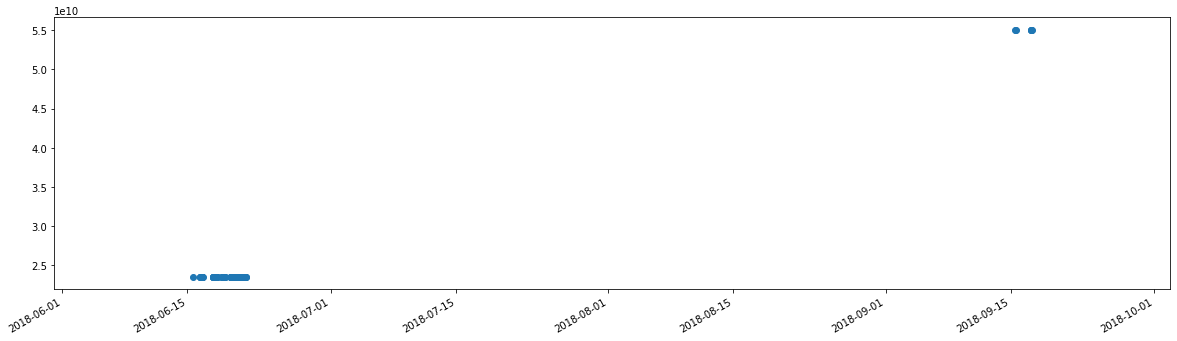

In [7]:
#now we can look for where the calibration is small
fig, ax = plt.subplots(figsize=(20,5))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.scatter(df_slim[df_slim.calibration < 0.5].index, df_slim[df_slim.calibration < 0.5].int_deliv_inv_ub)

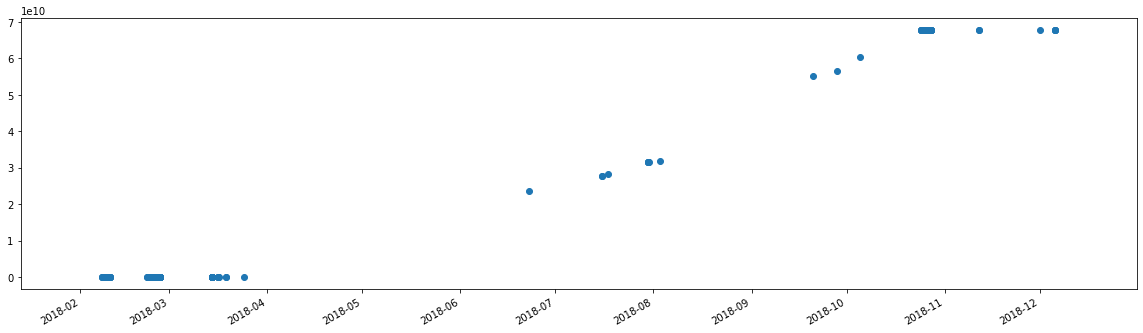

In [8]:
#now we can look for where the calibration is small
df_slim[df_slim.calibration.isna()]
#now we can look for where the calibration is small
fig, ax = plt.subplots(figsize=(20,5))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.scatter(df_slim[df_slim.calibration.isna()].index, df_slim[df_slim.calibration.isna()].int_deliv_inv_ub)

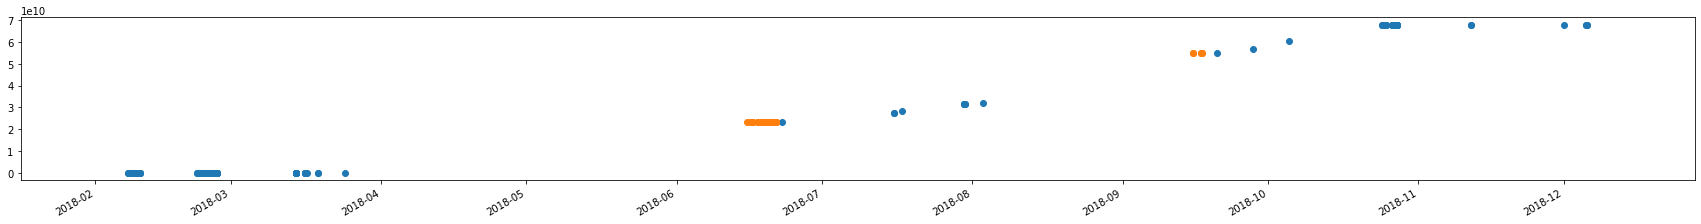

In [9]:
#now we can look for where the calibration is small
fig, ax = plt.subplots(figsize=(30,3))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.scatter(df_slim[df_slim.calibration.isna()].index, df_slim[df_slim.calibration.isna()].int_deliv_inv_ub)
ax.scatter(df_slim[df_slim.calibration < 0.5].index, df_slim[df_slim.calibration < 0.5].int_deliv_inv_ub)

In [20]:
df_cut = df_slim[df_slim.calibration.isna()]
df_cut[(df_cut.index > '2018-10-15 00:00:00') & (df_cut.index < '2018-11-01 00:00:00')]

,p2,int_deliv_inv_ub,calibration
laser_datetime,,,
2018-10-24 13:08:18,0.886490,6.781752e+10,NaN
2018-10-24 14:27:17,0.886490,6.781752e+10,NaN
2018-10-24 15:03:34,0.886490,6.781752e+10,NaN
2018-10-24 15:24:56,0.886490,6.781752e+10,NaN
2018-10-24 16:20:20,0.886490,6.781752e+10,NaN
...,...,...,...
2018-10-27 13:06:31,0.895224,6.782611e+10,NaN
2018-10-27 13:51:03,0.895224,6.782611e+10,NaN
2018-10-27 14:35:35,0.895224,6.782611e+10,NaN


In [17]:
df_cut = df_slim[df_slim.calibration < 0.5]
df_cut[df_cut.index > '2018-10-15 00:00:00']

,p2,int_deliv_inv_ub,calibration
laser_datetime,,,


In [27]:
#split the data into training, testing and validating
#select the data range (we'll select the part of the year when the beam was operating)
data_begin = '2018-05-12 08:00:00'

data_end = '2018-12-02 16:00:00'

june_gap_end = '2018-06-22 17:00:00' #after the june gap
sep_gap_end = '2018-09-20 11:00:00'  #after the september gap
sep_gap_begin = '2018-09-15 12:00:00' #begin september gap
oct_gap_begin = '2018-10-24 13:00:00' #begin october gap
oct_gap_end = '2018-10-27 16:00:00'   #end october gap

df_select = df_slim[(df_slim.index > data_begin) & (df_slim.index < data_end)]
df_select.to_csv('../data/select.csv')
#select the time ranges for train,valid,test datasets
#df_train_end = '2018-08-31 00:00:00'
#df_valid_end = '2018-10-15 00:00:00'
df_train_begin = june_gap_end
df_train_end = sep_gap_begin
df_valid_begin = sep_gap_end
df_valid_end = oct_gap_begin
df_test_begin = oct_gap_end
df_test_end = data_end

df_train = df_select[(df_select.index < df_train_end) & (df_select.index > df_train_begin)]
df_valid = df_select[(df_select.index < df_valid_end) & (df_select.index > df_valid_begin)]
df_test =  df_select[(df_select.index < df_test_end)  & (df_select.index > df_test_begin)]

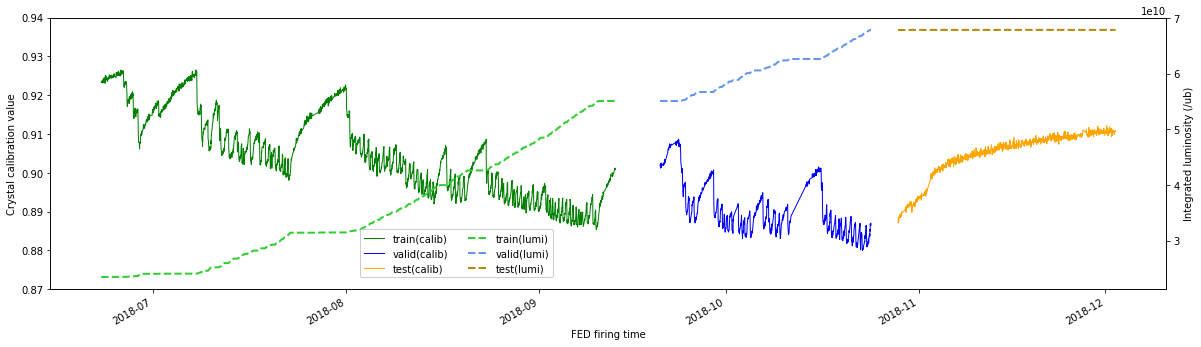

In [28]:
#now lets make a plot of our three datasets

fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_ylabel('Crystal calibration value')
ax1.set_xlabel('FED firing time')
ax1.set_ylim([0.87,0.94])
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.plot(df_train.index, df_train.p2, 
         label='train(calib)', color='green', linewidth=1, linestyle='solid')
ax1.plot(df_valid.index, df_valid.p2, 
         label='valid(calib)', color='blue', linewidth=1, linestyle='solid')
ax1.plot(df_test.index, df_test.p2, 
         label='test(calib)', color='orange', linewidth=1, linestyle='solid')

#lumi data on alternate y axis
ax2 = ax1.twinx()
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='train(lumi)', color='limegreen', linewidth=2, linestyle='dashed')
ax2.plot(df_valid.index, df_valid.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax2.plot(df_test.index, df_test.int_deliv_inv_ub, 
         label='test(lumi)', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#combined legend
fig.legend(ncol=2, loc = (0.3,0.2),framealpha=1)

fig.show()

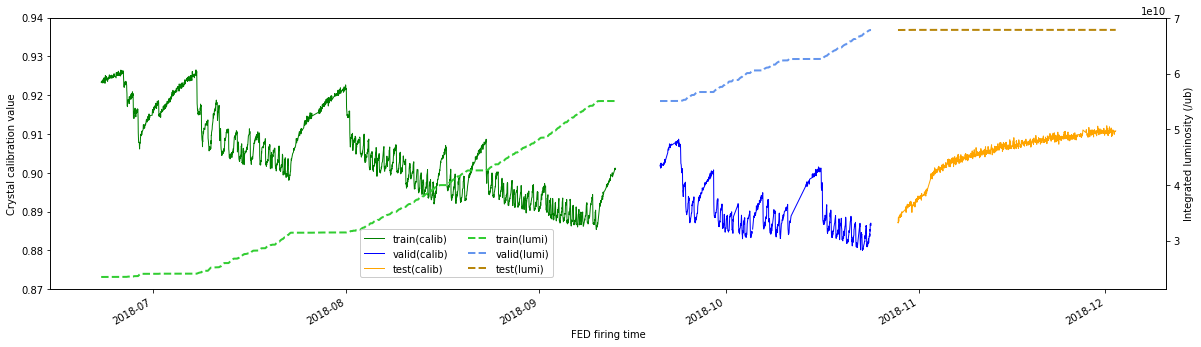

In [29]:
#now lets make a plot of our three datasets

fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_ylabel('Crystal calibration value')
ax1.set_xlabel('FED firing time')
ax1.set_ylim([0.87,0.94])
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.plot(df_train.index, df_train.calibration, 
         label='train(calib)', color='green', linewidth=1, linestyle='solid')
ax1.plot(df_valid.index, df_valid.calibration, 
         label='valid(calib)', color='blue', linewidth=1, linestyle='solid')
ax1.plot(df_test.index, df_test.calibration, 
         label='test(calib)', color='orange', linewidth=1, linestyle='solid')

#lumi data on alternate y axis
ax2 = ax1.twinx()
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='train(lumi)', color='limegreen', linewidth=2, linestyle='dashed')
ax2.plot(df_valid.index, df_valid.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax2.plot(df_test.index, df_test.int_deliv_inv_ub, 
         label='test(lumi)', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#combined legend
fig.legend(ncol=2, loc = (0.3,0.2),framealpha=1)


fig.show()

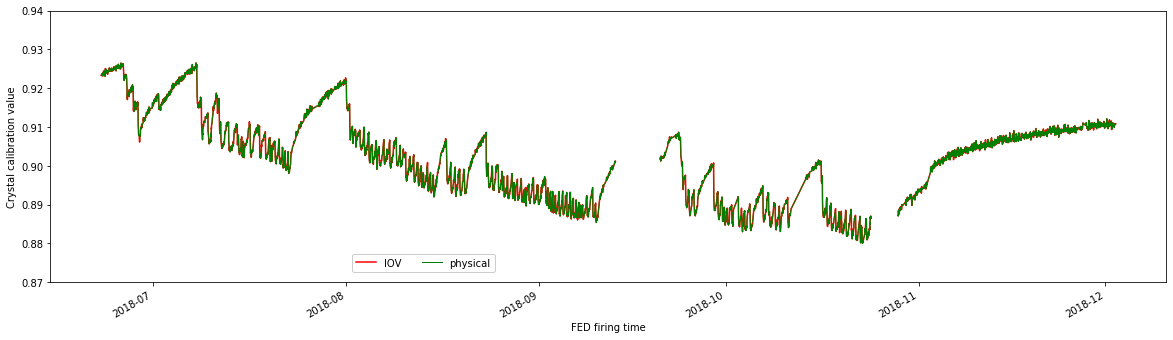

In [30]:
#now lets make a plot of our three datasets

fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_ylabel('Crystal calibration value')
ax1.set_xlabel('FED firing time')
ax1.set_ylim([0.87,0.94])
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.plot(df_train.index, df_train.p2, 
         label='IOV', color='red', linewidth=1.5, linestyle='solid')
ax1.plot(df_valid.index, df_valid.p2, 
          color='red', linewidth=1.5, linestyle='solid')
ax1.plot(df_test.index, df_test.p2, 
          color='red', linewidth=1.5, linestyle='solid')

ax1.plot(df_train.index, df_train.calibration, 
         label='physical', color='green', linewidth=1, linestyle='solid')
ax1.plot(df_valid.index, df_valid.calibration, 
          color='green', linewidth=1, linestyle='solid')
ax1.plot(df_test.index, df_test.calibration, 
          color='green', linewidth=1, linestyle='solid')



#combined legend
fig.legend(ncol=2, loc = (0.3,0.2),framealpha=1)


fig.show()

In [31]:
#lets look at the time spacing in the raw data
calib_timedelta = df_select.reset_index().laser_datetime.diff()
calib_td_mins = calib_timedelta.apply(lambda x: x.seconds/60)

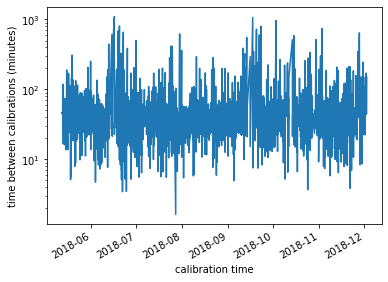

In [32]:
fig8, ax12 = plt.subplots()

ax12.set_ylabel('time between calibrations (minutes)')
ax12.set_xlabel('calibration time')
plt.setp(ax12.get_xticklabels(), rotation=30, horizontalalignment='right')
ax12.set_yscale('log')

ax12.plot(df_select.index, calib_td_mins, label='calib_td')
fig8.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


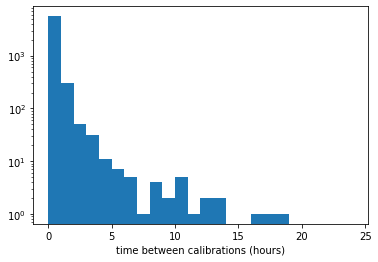

In [33]:
fig9, ax13 = plt.subplots()

calib_td_hrs = calib_timedelta.apply(lambda x: x.seconds/3600)
bins = [bin for bin in range(0, 24+1, 1)]
print(bins)
ax13.hist(calib_td_hrs, bins=bins)
ax13.set_xlabel('time between calibrations (hours)')
plt.setp(ax12.get_xticklabels(), rotation=30, horizontalalignment='right')
ax13.set_yscale('log')

fig9.show()

0         NaN
1    0.748889
2    0.751111
3    0.750000
4    0.789722
Name: laser_datetime, dtype: float64


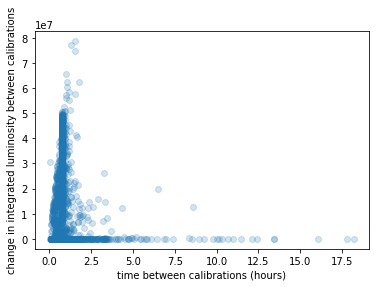

In [34]:
#lets look at the correlation between time delta and the change in integrated luminosity over the period
lumi_delta = df_select.int_deliv_inv_ub.diff()
print(calib_td_hrs.head())
fig, ax = plt.subplots()
ax.set_xlabel('time between calibrations (hours)')
ax.set_ylabel('change in integrated luminosity between calibrations')

ax.scatter(calib_td_hrs, lumi_delta, alpha='0.2')
fig.show()

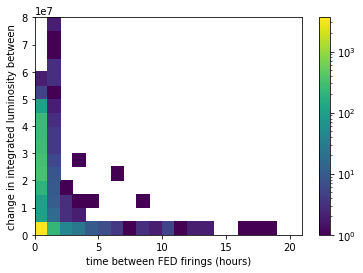

In [35]:
fig, ax = plt.subplots()
import matplotlib.colors as clrs
ax.set_xlabel('time between FED firings (hours)')
ax.set_ylabel('change in integrated luminosity between')

h = ax.hist2d(calib_td_hrs, lumi_delta, bins=[21, 16], range=[[0.0, 21.0], [0.0, 8e7]], norm=clrs.LogNorm())
fig.colorbar(h[3], ax=ax)
fig.show()

In [36]:
#now that we've looked at the raw data, we have to do a few manipulations.
#the first is to convert the data into an evenly spaced timeseries. We'll use a rolling average
import traces as ts

sampling=3600
avg_window = sampling*6
#windows are in seconds
train_calib_avg = ts.TimeSeries(df_train['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
train_lumi_avg = ts.TimeSeries(df_train['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

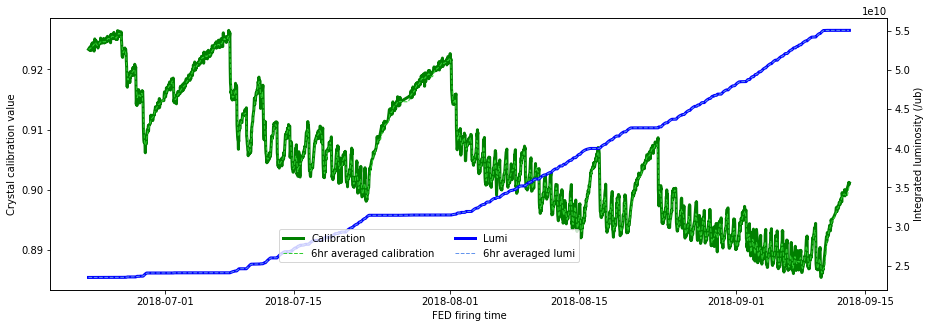

In [37]:
#lets plot the situation
fig2, ax3 = plt.subplots(figsize=(15,5))

ax3.set_ylabel('Crystal calibration value')
ax3.set_xlabel('FED firing time')

#calibration data
ax3.plot(df_train.index, df_train.p2, 
         label='Calibration', color='green', linewidth=3, linestyle='solid')
ax3.plot(train_calib_avg.index, train_calib_avg, 
         label='6hr averaged calibration', color='limegreen', linewidth=1, linestyle='dashed')

#lumi data on alternate y axis
ax4 = ax3.twinx()
ax4.set_ylabel('Integrated luminosity (/ub)')

ax4.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='Lumi', color='blue', linewidth=3, linestyle='solid')
ax4.plot(train_lumi_avg.index, train_lumi_avg, 
         label='6hr averaged lumi', color='cornflowerblue', linewidth=1, linestyle='dashed')

#combined legend
fig2.legend(ncol=2, loc = (0.3,0.2))

fig2.show()

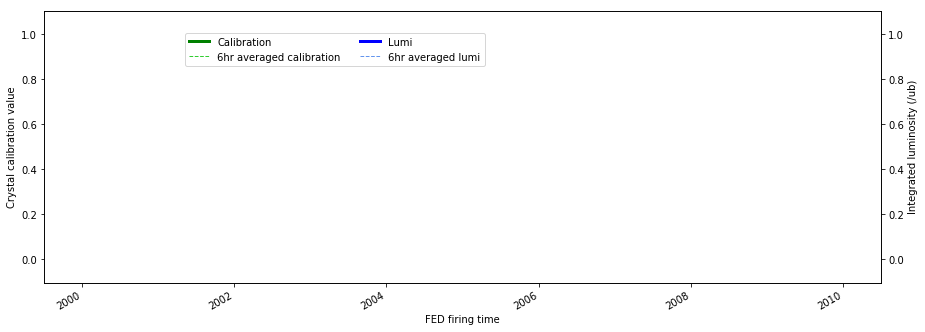

In [45]:
#lets plot a zoomed in view of the situation
fig3, ax5 = plt.subplots(figsize=(15,5))

ax5.set_ylabel('Crystal calibration value')
ax5.set_xlabel('FED firing time')
plt.setp(ax5.get_xticklabels(), rotation=30, horizontalalignment='right')

max_time = '2018-06-16 00:00:00'
min_time = '2018-06-01 00:00:00'

df_zoom = df_train[(df_train.index < max_time) & (df_train.index > min_time)]
train_calib_avg_zoom = train_calib_avg[(train_calib_avg.index < max_time) & (train_calib_avg.index > min_time)]
train_lumi_avg_zoom = train_lumi_avg[(train_lumi_avg.index < max_time) & (train_lumi_avg.index > min_time)]

#calibration data
ax5.plot(df_zoom.index, df_zoom.p2, 
         label='Calibration', color='green', linewidth=3, linestyle='solid')
ax5.plot(train_calib_avg_zoom.index, train_calib_avg_zoom, 
         label='6hr averaged calibration', color='limegreen', linewidth=1, linestyle='dashed')

#lumi data on alternate y axis
ax6 = ax5.twinx()
ax6.set_ylabel('Integrated luminosity (/ub)')

ax6.plot(df_zoom.index, df_zoom.int_deliv_inv_ub, 
         label='Lumi', color='blue', linewidth=3, linestyle='solid')
ax6.plot(train_lumi_avg_zoom.index, train_lumi_avg_zoom, 
         label='6hr averaged lumi', color='cornflowerblue', linewidth=1, linestyle='dashed')


#combined legend
fig3.legend(ncol=2, loc = (0.2,0.8))

fig3.show()
#you can see that it isn't perfect when there are gaps in the data.
#this can be tweaked by increasing the sliding average size, but then you lose resolution
#figuring out how to run it with a variable resolution would be tricky.
#but you could also choose a different interpolation technique to try to paste over the gaps

In [46]:
#now that we've explored the interpolation and made interpolated training data,
#we'll follow the same steps for the testing and validation data
valid_calib_avg = ts.TimeSeries(df_valid['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
valid_lumi_avg = ts.TimeSeries(df_valid['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

test_calib_avg = ts.TimeSeries(df_test['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
test_lumi_avg = ts.TimeSeries(df_test['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

#now we'll put it all back into dataframes
train = pd.DataFrame()
train['p2'] = train_calib_avg
train['int_deliv_inv_ub'] = train_lumi_avg
train.to_csv('../data/train_avg.csv')

valid = pd.DataFrame()
valid['p2'] = valid_calib_avg
valid['int_deliv_inv_ub'] = valid_lumi_avg
valid.to_csv('../data/valid_avg.csv')

test = pd.DataFrame()
test['p2'] = test_calib_avg
test['int_deliv_inv_ub'] = test_lumi_avg
test.to_csv('../data/test_avg.csv')

In [47]:
#now we need to de-trend the data so that it is flat over time
#for this I'll just apply differencing, since it is pretty simple
train = train.diff().dropna() #we run dropna, since the first row is NaN in a diff
valid = valid.diff().dropna()
test = test.diff().dropna()

train.to_csv('../data/train_diff.csv')
valid.to_csv('../data/valid_diff.csv')
test.to_csv('../data/test_diff.csv')

In [48]:
#now we'll scale the input data for the network
#scale values to between 0 and 1
#for the lumi data, there are many orders of magnitude within the lumi, we want to transform the lumi data to truncate very small values, and convert to log for higher orders of magnitude. and then we'll minmax scale it
#train['int_deliv_inv_ub'], train_floor = scale_shrinker(train['int_deliv_inv_ub'], 3, True, True) #set the floor at 10^-3 of the max, take the log_10
#valid['int_deliv_inv_ub'], _ = scale_shrinker(valid['int_deliv_inv_ub'], train_floor, True, False) #set the floor at train_floor, take the log_10
#test['int_deliv_inv_ub'], _ = scale_shrinker(test['int_deliv_inv_ub'], train_floor, True, False)

scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler() #we'll use the y-scaler later
y_scaler.fit(train[['p2']])
train[['p2', 'int_deliv_inv_ub']] = scaler.fit_transform(train)
valid[['p2', 'int_deliv_inv_ub']] = scaler.transform(valid)
test[['p2', 'int_deliv_inv_ub']] = scaler.transform(test)

/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


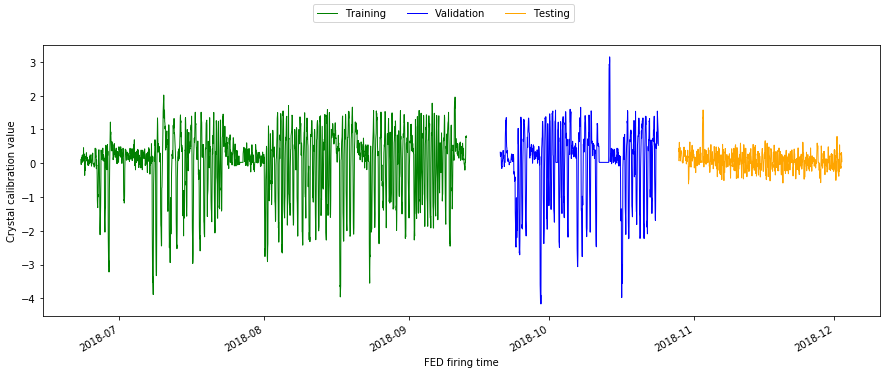

In [49]:
#lets plot the data 1 more time
fig4, ax7 = plt.subplots(figsize=(15,5))

ax7.set_ylabel('Crystal calibration value')
ax7.set_xlabel('FED firing time')
plt.setp(ax7.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax7.plot(train.index, train.p2, 
         label='Training', color='green', linewidth=1, linestyle='solid')
ax7.plot(valid.index, valid.p2, 
         label='Validation', color='blue', linewidth=1, linestyle='solid')
ax7.plot(test.index, test.p2, 
         label='Testing', color='orange', linewidth=1, linestyle='solid')
#legend
fig4.legend(ncol=3, loc = 'upper center')
fig4.show()

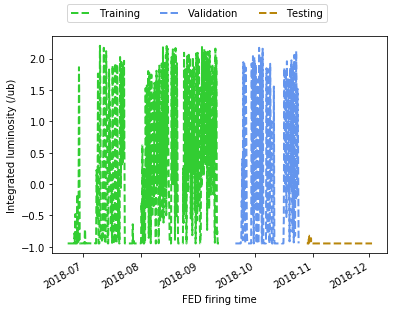

In [50]:
#lumi data on alternate y axis
fig5, ax8 = plt.subplots()
ax8.set_ylabel('Integrated luminosity (/ub)')
ax8.set_xlabel('FED firing time')
plt.setp(ax8.get_xticklabels(), rotation=30, horizontalalignment='right')

ax8.plot(train.index, train.int_deliv_inv_ub, 
         label='Training', color='limegreen', linewidth=2, linestyle='dashed')
ax8.plot(valid.index, valid.int_deliv_inv_ub, 
         label='Validation', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax8.plot(test.index, test.int_deliv_inv_ub, 
         label='Testing', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#legend
fig5.legend(ncol=3, loc = 'upper center')
fig5.show()

In [51]:
#now we'll save the data
train.to_csv('../data/train_final.csv')
test.to_csv('../data/test_final.csv')
valid.to_csv('../data/valid_final.csv')
full = train.append([valid,test])
full.to_csv('../data/full_final.csv')